In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-dataset-for-predictive-marketing-2023/ECommerce_consumer behaviour.csv


In [4]:
csv_filename = "ECommerce_consumer behaviour.csv"

full_path = os.path.join("/kaggle/input/ecommerce-dataset-for-predictive-marketing-2023/", csv_filename)
data = pd.read_csv(full_path)

data.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name
0,2425083,49125,1,2,18,NaN,17,1,0,13,pantry,baking ingredients
1,2425083,49125,1,2,18,NaN,91,2,0,16,dairy eggs,soy lactosefree
2,2425083,49125,1,2,18,NaN,36,3,0,16,dairy eggs,butter
3,2425083,49125,1,2,18,NaN,83,4,0,4,produce,fresh vegetables
4,2425083,49125,1,2,18,NaN,83,5,0,4,produce,fresh vegetables


In [3]:
data.dtypes

order_id                    int64
user_id                     int64
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
product_id                  int64
add_to_cart_order           int64
reordered                   int64
department_id               int64
department                 object
product_name               object
dtype: object

In [5]:
# --- 1. 缺失值處理 ---
data["days_since_prior_order"]=data["days_since_prior_order"].fillna(-1)
data.isnull().sum()

order_id                  0
user_id                   0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
department_id             0
department                0
product_name              0
dtype: int64

In [6]:
# --- 2. 特徵工程 (Feature Engineering) ---
# A. 新增 'total_items_per_order' (每筆訂單買了多少東西)
# 計算每個 order_id 有幾行資料
order_sizes = data.groupby('order_id').size().reset_index(name='total_items_per_order')
data = data.merge(order_sizes, on='order_id', how='left')
data

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name,total_items_per_order
0,2425083,49125,1,2,18,-1.0,17,1,0,13,pantry,baking ingredients,9
1,2425083,49125,1,2,18,-1.0,91,2,0,16,dairy eggs,soy lactosefree,9
2,2425083,49125,1,2,18,-1.0,36,3,0,16,dairy eggs,butter,9
3,2425083,49125,1,2,18,-1.0,83,4,0,4,produce,fresh vegetables,9
4,2425083,49125,1,2,18,-1.0,83,5,0,4,produce,fresh vegetables,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019496,3390742,199430,16,3,18,5.0,83,8,0,4,produce,fresh vegetables,8
2019497,458285,128787,42,2,19,3.0,115,1,1,7,beverages,water seltzer sparkling water,4
2019498,458285,128787,42,2,19,3.0,32,2,1,4,produce,packaged produce,4
2019499,458285,128787,42,2,19,3.0,32,3,1,4,produce,packaged produce,4


In [7]:
# B. average_days_between_orders (每個使用者的平均購買週期)
# 先將資料聚合為訂單層級，避免重複計算同一筆訂單
orders = data[['user_id', 'order_id', 'days_since_prior_order']].drop_duplicates(subset=['user_id', 'order_id'])

# 計算每位使用者的平均訂單間隔（排除第一次訂單，days_since_prior_order = -1）
orders_without_first_order = orders[orders['days_since_prior_order'] != -1]

# 計算平均值並轉換為 DataFrame，明確指定欄位名稱
user_avg_days = (
    orders_without_first_order
    .groupby('user_id')['days_since_prior_order']
    .mean()
    .reset_index()
    .rename(columns={'days_since_prior_order': 'average_days_between_orders'})
)

# 將計算結果合併回原始資料（left join 保留所有原始資料）
data = data.merge(user_avg_days, on='user_id', how='left')

# 顯示結果
data

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name,total_items_per_order,average_days_between_orders
0,2425083,49125,1,2,18,-1.0,17,1,0,13,pantry,baking ingredients,9,14.000000
1,2425083,49125,1,2,18,-1.0,91,2,0,16,dairy eggs,soy lactosefree,9,14.000000
2,2425083,49125,1,2,18,-1.0,36,3,0,16,dairy eggs,butter,9,14.000000
3,2425083,49125,1,2,18,-1.0,83,4,0,4,produce,fresh vegetables,9,14.000000
4,2425083,49125,1,2,18,-1.0,83,5,0,4,produce,fresh vegetables,9,14.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019496,3390742,199430,16,3,18,5.0,83,8,0,4,produce,fresh vegetables,8,8.750000
2019497,458285,128787,42,2,19,3.0,115,1,1,7,beverages,water seltzer sparkling water,4,3.714286
2019498,458285,128787,42,2,19,3.0,32,2,1,4,produce,packaged produce,4,3.714286
2019499,458285,128787,42,2,19,3.0,32,3,1,4,produce,packaged produce,4,3.714286


In [17]:
# B. average_days_between_orders (每個使用者的平均購買週期)
# 先計算每個使用者的平均天數 (排除 -1，因為 -1 代表無上次紀錄)
# 這裡使用 transform 將計算結果直接填回每一列，方便後續對個別交易做 EDA

# 定義計算平均值的函式 (排除 -1)
# def calculate_avg_days(series):
    # valid_days = series[series != -1]
    # return valid_days.mean() if not valid_days.empty else 0

# 使用 transform 讓每個 user_id 的所有 row 都會有該 user 的平均天數
# data['average_days_between_orders'] = data.groupby('user_id')['days_since_prior_order'].transform(calculate_avg_days)
# data

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name,total_items_per_order,average_days_between_orders
0,2425083,49125,1,2,18,-1.0,17,1,0,13,pantry,baking ingredients,9,15.611111
1,2425083,49125,1,2,18,-1.0,91,2,0,16,dairy eggs,soy lactosefree,9,15.611111
2,2425083,49125,1,2,18,-1.0,36,3,0,16,dairy eggs,butter,9,15.611111
3,2425083,49125,1,2,18,-1.0,83,4,0,4,produce,fresh vegetables,9,15.611111
4,2425083,49125,1,2,18,-1.0,83,5,0,4,produce,fresh vegetables,9,15.611111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019496,3390742,199430,16,3,18,5.0,83,8,0,4,produce,fresh vegetables,8,8.629032
2019497,458285,128787,42,2,19,3.0,115,1,1,7,beverages,water seltzer sparkling water,4,3.852941
2019498,458285,128787,42,2,19,3.0,32,2,1,4,produce,packaged produce,4,3.852941
2019499,458285,128787,42,2,19,3.0,32,3,1,4,produce,packaged produce,4,3.852941


## EDA

### 資料粒度說明

本資料集的原始粒度是「商品列」：一筆訂單中的每個商品都佔一列。

為了避免「大訂單加權」問題（同一筆訂單的屬性被重複計算多次），我們需要區分：
- **訂單層級分析**：計算訂單數量、下單時間、訂單間隔等 → 使用訂單層級資料
- **商品層級分析**：計算商品偏好、部門分布等 → 使用原始商品列資料

In [8]:
# ============================================
# 建立訂單層級資料表 (Order-Level Data)
# ============================================
# 目的：避免同一筆訂單的屬性（如下單時間、訂單間隔）被重複計算

# 選擇訂單層級的欄位，並去除重複的訂單
orders_level = data[['order_id', 'user_id', 'order_dow', 'order_hour_of_day', 
                     'days_since_prior_order']].drop_duplicates(subset='order_id')

print(f"✅ 訂單層級資料已建立")
print(f"   原始資料列數（商品列）: {len(data):,}")
print(f"   訂單層級資料列數: {len(orders_level):,}")
print(f"   每筆訂單平均商品數: {len(data) / len(orders_level):.2f}")

orders_level.head()

✅ 訂單層級資料已建立
   原始資料列數（商品列）: 2,019,501
   訂單層級資料列數: 200,000
   每筆訂單平均商品數: 10.10


,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order
0,2425083,49125,2,18,-1.0
9,1944304,162867,3,17,-1.0
22,1201011,147243,0,16,3.0
37,1906860,195275,1,11,3.0
48,2766469,58222,6,11,6.0


In [9]:
user_order_cnt = orders_level.groupby('user_id')['order_id'].nunique()

print(user_order_cnt.describe())
print(user_order_cnt.quantile([0.5, 0.9, 0.95, 0.99]))
print("max =", user_order_cnt.max())


count    105273.000000
mean          1.899822
std           1.394365
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          15.000000
Name: order_id, dtype: float64
0.50    1.0
0.90    4.0
0.95    5.0
0.99    7.0
Name: order_id, dtype: float64
max = 15


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# bins   = [1,2,3,5,8,11,16]   # right=False => [1,2), [2,3), ...
# labels = ["1","2","3-4","5-7","8-10","11-15"]

# binned = pd.cut(user_order_cnt, bins=bins, right=False, labels=labels, include_lowest=True)
# freq = binned.value_counts().reindex(labels).fillna(0).astype(int)
# prop = freq / freq.sum()

# def autopct_fmt(pct):
#     return f"{pct:.0f}%" if pct >= 3 else ""   # 小於 3% 不印，避免擠

# plt.figure(figsize=(8,6))
# plt.pie(
#     prop.values,
#     labels=labels,
#     startangle=90,
#     autopct=autopct_fmt,
#     pctdistance=0.78,
#     labeldistance=1.12,
#     wedgeprops=dict(width=0.35, edgecolor="white")
# )
# plt.title("Fig 2: Orders made by users (binned, max=15)")
# plt.tight_layout()
# plt.show()


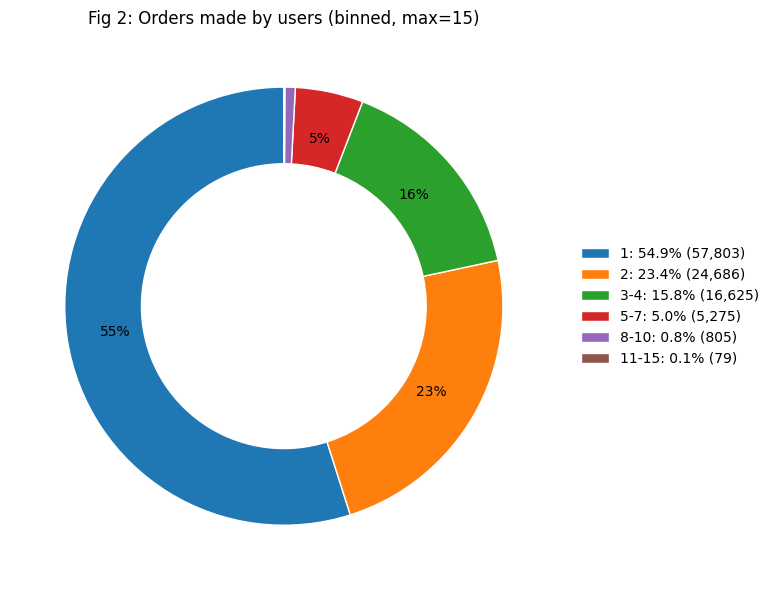

In [12]:
# import matplotlib.pyplot as plt

# # freq, prop, labels 你已經算好了（freq 是各箱人數，prop 是比例）
# # 如果你還沒做：freq = ... ; prop = ... ; labels = ...

# def autopct_fmt(pct):
#     return f"{pct:.0f}%" if pct >= 3 else ""  # 小於 3% 不印

# fig, ax = plt.subplots(figsize=(9, 6))

# wedges, *_ = ax.pie(
#     prop.values,
#     startangle=90,
#     labels=None,                 # <-- 不在圓周放 label
#     autopct=autopct_fmt,
#     pctdistance=0.78,
#     wedgeprops=dict(width=0.35, edgecolor="white", linewidth=1),
# )

# legend_labels = [
#     f"{lab}: {p:.1%} ({c:,})" for lab, p, c in zip(labels, prop.values, freq.values)
# ]
# ax.legend(
#     wedges, legend_labels,
#     loc="center left", bbox_to_anchor=(1.02, 0.5),
#     frameon=False
# )

# ax.set_title("Fig 2: Orders made by users (binned, max=15)")
# plt.tight_layout()
# plt.show()


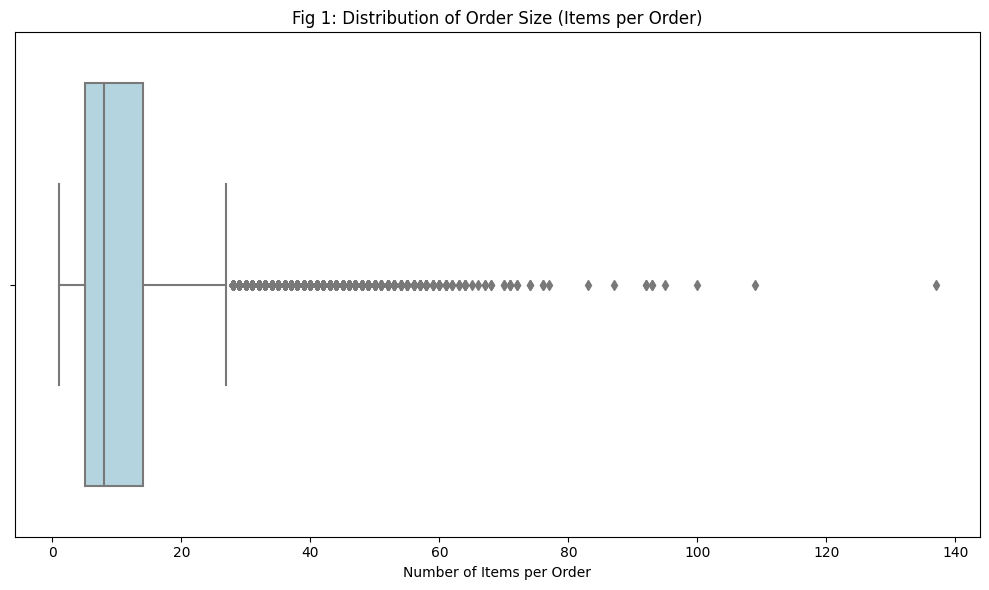

📊 訂單大小統計:
   平均: 10.10 件
   中位數: 8 件
   最大: 137 件


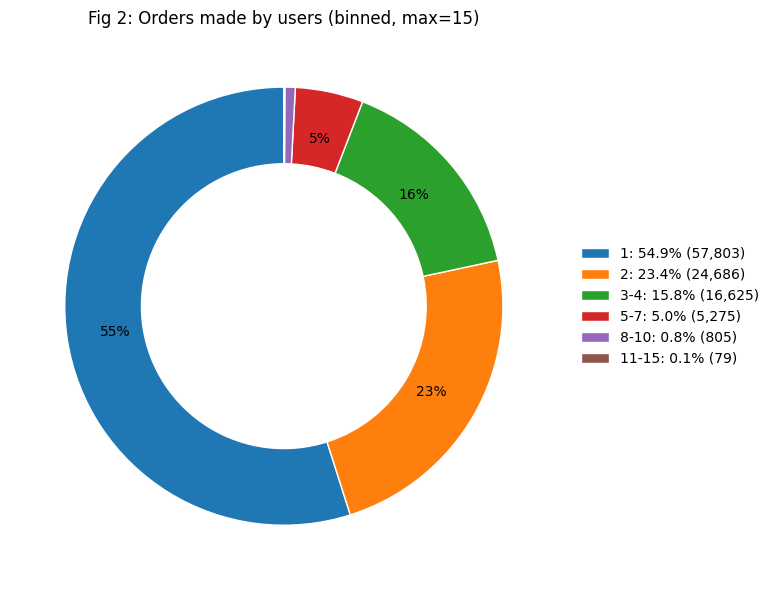

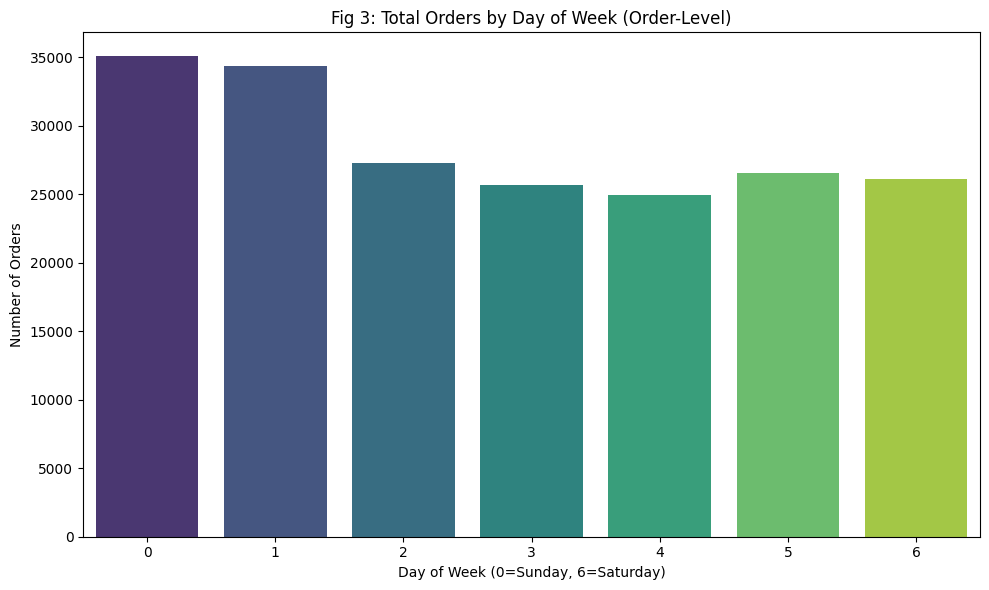

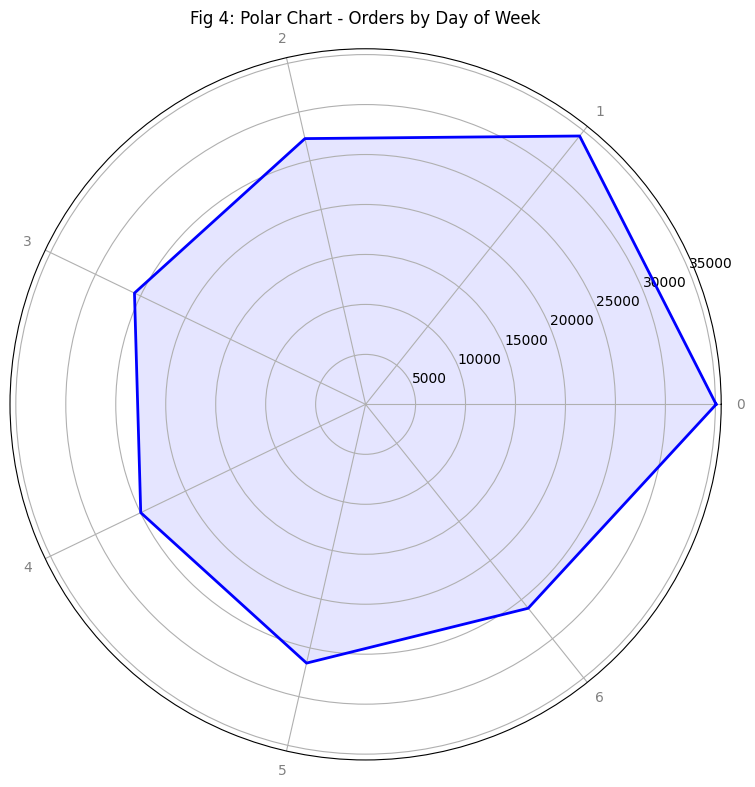

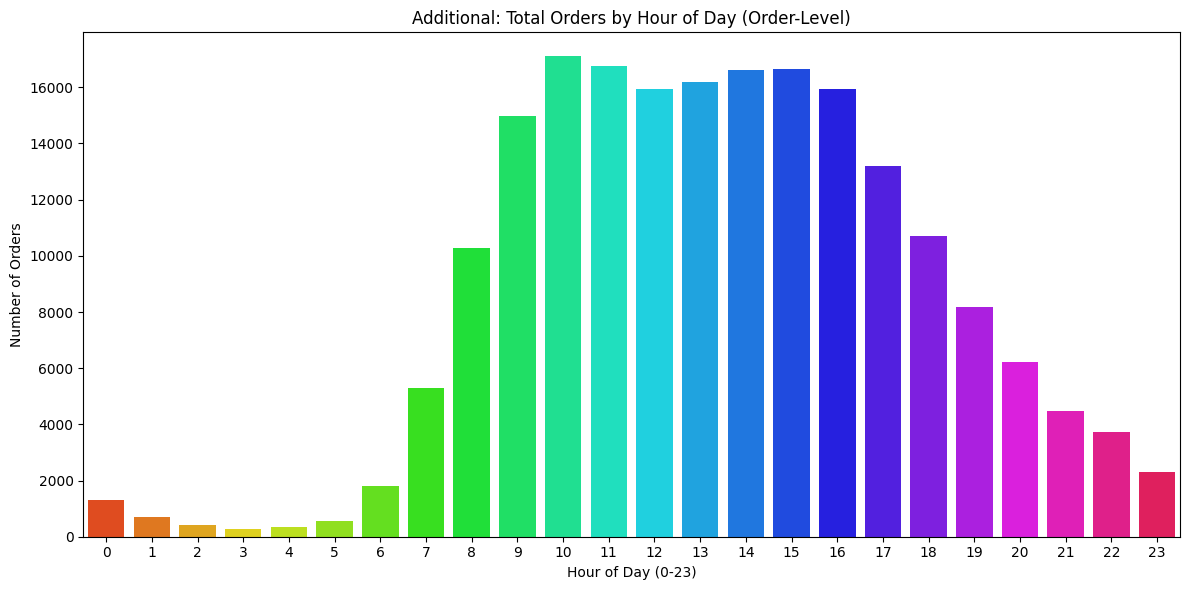

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# ---------------------------------------------------------
# Fig 1. 訂單大小分布 (Distribution of Order Size)
# ---------------------------------------------------------
# 修正：原本的 add_to_cart_order 箱型圖容易誤導
# 改為直接分析訂單大小（total_items_per_order）
plt.figure(figsize=(10, 6))
order_size_data = data[['order_id', 'total_items_per_order']].drop_duplicates()
sns.boxplot(x=order_size_data['total_items_per_order'], color='lightblue')
plt.title('Fig 1: Distribution of Order Size (Items per Order)')
plt.xlabel('Number of Items per Order')
plt.tight_layout()
plt.savefig('fig1_boxplot_order_size.png')
plt.show()

print(f"📊 訂單大小統計:")
print(f"   平均: {order_size_data['total_items_per_order'].mean():.2f} 件")
print(f"   中位數: {order_size_data['total_items_per_order'].median():.0f} 件")
print(f"   最大: {order_size_data['total_items_per_order'].max():.0f} 件")

# ---------------------------------------------------------
# Fig 2. 使用者訂單頻率圓餅圖 (Pie Chart for User Order Ranges)
# ---------------------------------------------------------

bins   = [1,2,3,5,8,11,16]   # right=False => [1,2), [2,3), ...
labels = ["1","2","3-4","5-7","8-10","11-15"]

binned = pd.cut(user_order_cnt, bins=bins, right=False, labels=labels, include_lowest=True)
freq = binned.value_counts().reindex(labels).fillna(0).astype(int)
prop = freq / freq.sum()

def autopct_fmt(pct):
    return f"{pct:.0f}%" if pct >= 3 else ""  # 小於 3% 不印

fig, ax = plt.subplots(figsize=(9, 6))

wedges, *_ = ax.pie(
    prop.values,
    startangle=90,
    labels=None,                 # <-- 不在圓周放 label
    autopct=autopct_fmt,
    pctdistance=0.78,
    wedgeprops=dict(width=0.35, edgecolor="white", linewidth=1),
)

legend_labels = [
    f"{lab}: {p:.1%} ({c:,})" for lab, p, c in zip(labels, prop.values, freq.values)
]
ax.legend(
    wedges, legend_labels,
    loc="center left", bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

ax.set_title("Fig 2: Orders made by users (binned, max=15)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Fig 3 & 4. 購買週間趨勢 (Day of Week Analysis)
# ---------------------------------------------------------
# ✅ 修正：使用訂單層級資料，避免大訂單重複計算
dow_counts = orders_level.groupby('order_dow').size().sort_index()

# 3-1. 長條圖 (Bar Chart)
plt.figure(figsize=(10, 6))
sns.barplot(x=dow_counts.index, y=dow_counts.values, palette="viridis")
plt.title('Fig 3: Total Orders by Day of Week (Order-Level)')
plt.xlabel('Day of Week (0=Sunday, 6=Saturday)')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.savefig('fig3_bar_dow.png')
plt.show()

# 3-2. 雷達圖 (Polar Chart - 論文 Fig 4)
# 準備雷達圖數據 (需要閉合圓圈)
categories = dow_counts.index.astype(str)
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1] # 閉合

values = dow_counts.values.tolist()
values += values[:1] # 閉合

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
# 設定刻度與標籤
plt.xticks(angles[:-1], categories, color='grey', size=10)

# 畫線與填色
ax.plot(angles, values, linewidth=2, linestyle='solid', color='blue')
ax.fill(angles, values, 'blue', alpha=0.1)

plt.title('Fig 4: Polar Chart - Orders by Day of Week')
plt.tight_layout()
plt.savefig('fig4_polar_dow.png')
plt.show()

# ---------------------------------------------------------
# Additional. 購買時段趨勢 (Hour of Day)
# ---------------------------------------------------------
# ✅ 修正：使用訂單層級資料
# hod_counts = orders_level.groupby('order_hour_of_day').size().sort_index()

# plt.figure(figsize=(12, 6))
# sns.barplot(x=hod_counts.index, y=hod_counts.values, color="skyblue")
# plt.title('Additional: Total Orders by Hour of Day (Order-Level)')
# plt.xlabel('Hour of Day (0-23)')
# plt.ylabel('Number of Orders')
# plt.tight_layout()
# plt.savefig('fig_extra_hour_of_day.png')
# plt.show()
hod_counts = orders_level.groupby('order_hour_of_day').size().sort_index()

df = hod_counts.reset_index()
df.columns = ['order_hour_of_day', 'count']

palette = sns.color_palette("rainbow", n_colors=len(df))  # 或改 "hsv" 更飽和

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df,
    x='order_hour_of_day',
    y='count',
    hue='order_hour_of_day',   # 用 hue 讓每個 hour 吃到不同顏色
    palette = sns.color_palette("hsv", n_colors=len(df)),
    dodge=False
)

# 移除 legend（不同 seaborn 版本 legend 物件名稱略有差異，這樣寫最穩）
leg = ax.get_legend()
if leg is not None:
    leg.remove()

plt.title('Additional: Total Orders by Hour of Day (Order-Level)')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.savefig('fig_extra_hour_of_day.png')
plt.show()


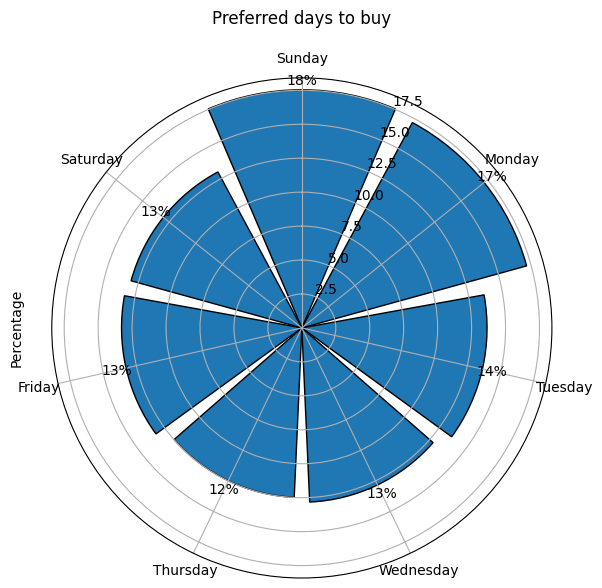

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 1) 計算各 day-of-week 的比例
dow_counts = orders_level['order_dow'].value_counts().sort_index()
dow_pct = dow_counts / dow_counts.sum() * 100

# 2) 設定星期名稱（Instacart 常見：0=Sunday, 1=Monday, ... 6=Saturday）
dow_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# 3) 極座標角度（7 等分）
N = 7
angles = np.linspace(0, 2*np.pi, N, endpoint=False)

# 讓每個 bar 對齊刻度中心
values = dow_pct.reindex(range(7)).values
width = 2*np.pi / N * 0.9

# 4) 畫圖
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot(111, polar=True)

bars = ax.bar(angles, values, width=width, edgecolor='black', linewidth=1)

# 5) 角度軸顯示星期全名
ax.set_xticks(angles)
ax.set_xticklabels(dow_labels)

# 6) 從上方開始、順時針（更像你附圖）
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# 7) 半徑軸（百分比）
ax.set_ylabel('Percentage', labelpad=20)
ax.set_title('Preferred days to buy', pad=20)

# 8) 在 bar 上標百分比
for angle, v in zip(angles, values):
    ax.text(angle, v + 0.7, f"{v:.0f}%", ha='center', va='center')

plt.tight_layout()
plt.show()


📊 訂單間隔統計:
   總訂單數: 200,000
   有上次訂單記錄的訂單數: 187,746
   首次購買訂單數: 12,254
   平均間隔天數: 11.00 天
   中位數間隔: 7 天


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


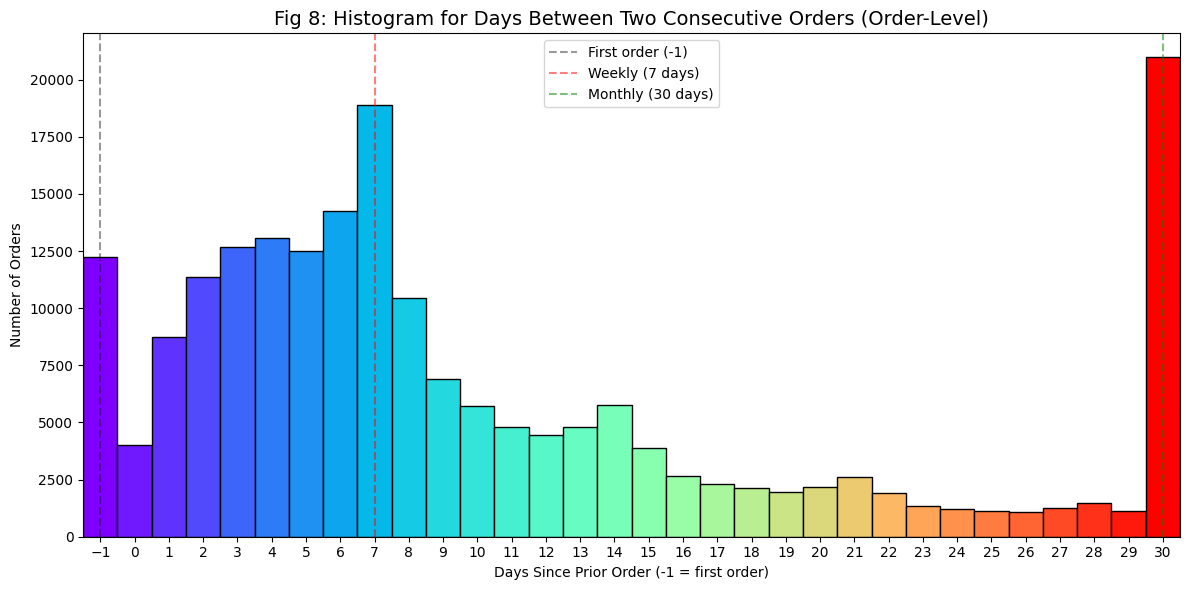


💡 觀察:
   7 天週期訂單數: 18,882
   30 天週期訂單數: 20,982


In [19]:
# ============================================
# Fig 8. 訂單間隔分析 (Days Between Consecutive Orders)
# ============================================
# ✅ 修正：使用訂單層級資料，排除首次購買 (-1)

# 過濾資料：只保留有上次訂單記錄的訂單（排除首次購買）
orders_with_prior = orders_level[orders_level['days_since_prior_order'] != -1].copy()

print(f"📊 訂單間隔統計:")
print(f"   總訂單數: {len(orders_level):,}")
print(f"   有上次訂單記錄的訂單數: {len(orders_with_prior):,}")
print(f"   首次購買訂單數: {len(orders_level) - len(orders_with_prior):,}")
print(f"   平均間隔天數: {orders_with_prior['days_since_prior_order'].mean():.2f} 天")
print(f"   中位數間隔: {orders_with_prior['days_since_prior_order'].median():.0f} 天")

# 繪製直方圖 (Histogram)
# 繪製直方圖 (Histogram) —— ✅ 改成包含 -1
days_for_plot = orders_level['days_since_prior_order']  # 你前面已經 fillna(-1) 了

# 讓 -1, 0, 1, ... 30 每個整數各自一根柱
bins = np.arange(-1.5, 31.5, 1)

plt.figure(figsize=(12, 6))
ax = sns.histplot(
    x=days_for_plot,
    bins=bins,
    kde=False,
    edgecolor='black'
)

# 彩虹漸層上色（由左到右）
colors = plt.cm.rainbow(np.linspace(0, 1, len(ax.patches)))
for p, c in zip(ax.patches, colors):
    p.set_facecolor(c)

plt.title('Fig 8: Histogram for Days Between Two Consecutive Orders (Order-Level)', fontsize=14)
plt.xlabel('Days Since Prior Order (-1 = first order)')
plt.ylabel('Number of Orders')

# x 軸把 -1 也顯示出來
plt.xticks(range(-1, 31, 1))
plt.xlim(-1.5, 30.5)

# 標記關鍵時間點（加上 -1）
plt.axvline(x=-1, color='black', linestyle='--', alpha=0.4, label='First order (-1)')
plt.axvline(x=7,  color='red',   linestyle='--', alpha=0.5, label='Weekly (7 days)')
plt.axvline(x=30, color='green', linestyle='--', alpha=0.5, label='Monthly (30 days)')
plt.legend()

plt.tight_layout()
plt.savefig('fig8_order_frequency.png')
plt.show()


print(f"\n💡 觀察:")
print(f"   7 天週期訂單數: {len(orders_with_prior[orders_with_prior['days_since_prior_order'] == 7]):,}")
print(f"   30 天週期訂單數: {len(orders_with_prior[orders_with_prior['days_since_prior_order'] == 30]):,}")

# Apriori 關聯規則分析 (Association Rule Mining)
使用 Apriori 演算法挖掘「商品之間的關聯性」，找出經常一起被購買的商品組合

In [9]:
# ============================================
# Apriori 步驟 1：建立購物籃矩陣 (Basket Matrix)
# ============================================
# 目標：將資料轉換為「訂單-商品」矩陣，每個格子代表該商品在該訂單中出現的次數

# 複製資料，避免影響原始資料
patterns = data.copy()

# 使用 crosstab 建立交叉表
# 行（index）：每筆訂單（order_id）
# 列（columns）：每種商品（product_name）
# 值：該商品在該訂單中出現的次數（通常是 0 或 1）
basket = pd.crosstab(index=patterns['order_id'], columns=patterns['product_name'])

# 轉換為布林值（Boolean）
# True：該商品在此訂單中有被購買（數量 > 0）
# False：該商品在此訂單中沒有被購買（數量 = 0）
basket_bool = (basket > 0)

# 顯示購物籃矩陣
basket_bool

product_name,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
order_id,,,,,,,,,,,,,,,,,,,,,
10,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
38,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
56,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3420991,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3421019,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3421027,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [11]:
# ============================================
# Apriori 步驟 2：找出頻繁項目集 (Frequent Itemsets)
# ============================================
# 使用 mlxtend 套件的 apriori 演算法
from mlxtend.frequent_patterns import apriori, association_rules

# 參數說明：
# - min_support=0.05：最小支持度 5%，表示至少要有 5% 的訂單包含該商品組合
# - use_colnames=True：保留商品名稱（而非使用欄位索引）
frequent_itemsets = apriori(basket_bool, min_support=0.05, use_colnames=True)

# 顯示頻繁項目集
# support：支持度（該商品組合出現的比例）
# itemsets：商品組合
frequent_itemsets

,support,itemsets
0,0.076635,(baking ingredients)
1,0.163865,(bread)
2,0.067765,(breakfast bakery)
3,0.074330,(butter)
4,0.069305,(candy chocolate)
...,...,...
151,0.051295,"(packaged vegetables fruits, milk, yogurt)"
152,0.051915,"(packaged cheese, packaged vegetables fruits, ..."
153,0.062535,"(fresh vegetables, packaged vegetables fruits,..."
154,0.068325,"(fresh vegetables, packaged cheese, packaged v..."


In [12]:
# ============================================
# Apriori 步驟 3：生成關聯規則 (Association Rules)
# ============================================
# 從頻繁項目集中，找出有意義的「if-then」規則
# 例如：「如果買了牛奶，則會買麵包」

# 參數說明：
# - metric='confidence'：使用信賴度作為評估指標
# - min_threshold=0.8：最小信賴度 80%，表示規則的可信度至少要達到 80%
association_rule = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.8)

# 顯示關聯規則
# antecedents：前項（條件）
# consequents：後項（結果）
# confidence：信賴度（當前項成立時，後項也成立的機率）
# lift：提升度（比隨機情況下高出多少倍）
association_rule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(fresh herbs),(fresh vegetables),0.093005,0.444360,0.078655,0.845707,1.903203,1.0,0.037327,3.601205,0.523233,0.171470,0.722315,0.511357
1,"(bread, packaged vegetables fruits)",(fresh fruits),0.077055,0.555995,0.062430,0.810201,1.457208,1.0,0.019588,2.339337,0.339951,0.109407,0.572528,0.461243
2,"(packaged vegetables fruits, eggs)",(fresh fruits),0.068650,0.555995,0.055045,0.801821,1.442137,1.0,0.016876,2.240422,0.329183,0.096638,0.553656,0.450412
3,"(fresh herbs, fresh fruits)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,1.0,0.030650,4.683872,0.533229,0.136553,0.786501,0.510241
4,"(fresh vegetables, soy lactosefree)",(fresh fruits),0.094120,0.555995,0.075620,0.803442,1.445053,1.0,0.023290,2.258905,0.339983,0.131629,0.557308,0.469725
5,"(fresh vegetables, yogurt)",(fresh fruits),0.144660,0.555995,0.118420,0.818609,1.472332,1.0,0.037990,2.447781,0.375062,0.203389,0.591467,0.515798
6,"(packaged vegetables fruits, frozen produce)",(fresh fruits),0.066985,0.555995,0.054415,0.812346,1.461067,1.0,0.017172,2.366084,0.338225,0.095706,0.577361,0.455108
7,"(packaged vegetables fruits, milk)",(fresh fruits),0.107425,0.555995,0.087450,0.814056,1.464143,1.0,0.027722,2.387847,0.355160,0.151831,0.581213,0.485671
8,"(packaged vegetables fruits, soy lactosefree)",(fresh fruits),0.081385,0.555995,0.066960,0.822756,1.479790,1.0,0.021710,2.505050,0.352954,0.117387,0.600806,0.471594
9,"(packaged vegetables fruits, yogurt)",(fresh fruits),0.127910,0.555995,0.105790,0.827066,1.487542,1.0,0.034673,2.567481,0.375821,0.182991,0.610513,0.508669


In [13]:
# ============================================
# Apriori 步驟 4：排序關聯規則
# ============================================
# 依照信賴度（confidence）和提升度（lift）排序，找出最有價值的規則
# 降序排列（False = 降序），優先顯示信賴度和提升度最高的規則
association_rule.sort_values(['confidence','lift'], ascending=[False, False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
3,"(fresh herbs, fresh fruits)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,1.0,0.030650,4.683872,0.533229,0.136553,0.786501,0.510241
12,"(fresh vegetables, packaged vegetables fruits,...",(fresh fruits),0.087995,0.555995,0.076240,0.866413,1.558311,1.0,0.027315,3.323711,0.392848,0.134284,0.699131,0.501768
10,"(fresh vegetables, packaged vegetables fruits,...",(fresh fruits),0.073075,0.555995,0.062535,0.855765,1.539159,1.0,0.021906,3.078336,0.377910,0.110382,0.675149,0.484119
0,(fresh herbs),(fresh vegetables),0.093005,0.444360,0.078655,0.845707,1.903203,1.0,0.037327,3.601205,0.523233,0.171470,0.722315,0.511357
11,"(fresh vegetables, packaged cheese, packaged v...",(fresh fruits),0.081970,0.555995,0.068325,0.833537,1.499180,1.0,0.022750,2.667284,0.362699,0.119944,0.625087,0.478212
9,"(packaged vegetables fruits, yogurt)",(fresh fruits),0.127910,0.555995,0.105790,0.827066,1.487542,1.0,0.034673,2.567481,0.375821,0.182991,0.610513,0.508669
8,"(packaged vegetables fruits, soy lactosefree)",(fresh fruits),0.081385,0.555995,0.066960,0.822756,1.479790,1.0,0.021710,2.505050,0.352954,0.117387,0.600806,0.471594
5,"(fresh vegetables, yogurt)",(fresh fruits),0.144660,0.555995,0.118420,0.818609,1.472332,1.0,0.037990,2.447781,0.375062,0.203389,0.591467,0.515798
7,"(packaged vegetables fruits, milk)",(fresh fruits),0.107425,0.555995,0.087450,0.814056,1.464143,1.0,0.027722,2.387847,0.355160,0.151831,0.581213,0.485671
6,"(packaged vegetables fruits, frozen produce)",(fresh fruits),0.066985,0.555995,0.054415,0.812346,1.461067,1.0,0.017172,2.366084,0.338225,0.095706,0.577361,0.455108


# 協同過濾推薦系統 (Collaborative Filtering)

本節實作**項目基礎協同過濾 (Item-Based CF)**，根據文獻研究，這是最適合電商推薦的演算法。

**為什麼選擇項目基礎 CF？**
- ✅ 執行效率高，適合即時推薦
- ✅ 記憶體需求低
- ✅ 準確度高（文獻：AUC=0.89, F1=0.81, Accuracy=87%）
- ❌ 使用者基礎 CF 有記憶體問題，不適合大規模應用

In [9]:
import matplotlib.pyplot as plt
import matplotlib
# 設定繁體中文字型（依序嘗試可用字體）
matplotlib.rcParams['font.sans-serif'] = [
    'Microsoft JhengHei',      # 微軟正黑體 (Windows 繁中)
    'Arial Unicode MS',        # macOS
    'Noto Sans CJK TC',        # Google 開源繁中
    'Noto Sans TC',            # Google 開源繁中
    'PingFang TC',             # macOS 繁中
    'Heiti TC',                # macOS 繁中
    'Microsoft YaHei',         # 微軟雅黑 (簡中)
    'SimHei',                  # 黑體 (簡中)
    'DejaVu Sans'              # 後備字體
]
matplotlib.rcParams['axes.unicode_minus'] = False

In [11]:
import numpy as np
import pandas as pd
from collections import defaultdict

from surprise import Dataset, Reader, KNNBasic, SVD, NormalPredictor, BaselineOnly
from sklearn.metrics import roc_auc_score

from tqdm.auto import tqdm  # ✅ 進度條

# ----------------------------
# 0) 準備二元互動資料（買過=1）
# ----------------------------
rs = data.copy()
rs['user_id'] = rs['user_id'].astype(str)
rs['product_id'] = rs['product_id'].astype(str)

pos_df = rs[['user_id','product_id']].drop_duplicates()
all_items = pos_df['product_id'].unique().tolist()

user_pos = pos_df.groupby('user_id')['product_id'].apply(lambda x: list(set(x))).to_dict()

# 5-fold 需要每個 user 至少有 5 個正樣本，否則某些 fold 會沒有 test positives
user_pos = {u: items for u, items in user_pos.items() if len(items) >= 5}
users = list(user_pos.keys())

print("Users used:", len(users))

# ----------------------------
# 1) 幫每個 user 的正樣本做 5-fold（within-user）
# ----------------------------
def make_user_folds(user_pos, n_folds=5, seed=42):
    rng = np.random.default_rng(seed)
    folds = [defaultdict(set) for _ in range(n_folds)]
    for u, items in user_pos.items():
        items = np.array(items, dtype=object)
        rng.shuffle(items)
        splits = np.array_split(items, n_folds)
        for f in range(n_folds):
            folds[f][u] = set(splits[f])
    return folds

fold_test_pos = make_user_folds(user_pos, n_folds=5, seed=42)

# ----------------------------
# 2) 指標：Precision@K / Recall@K / NDCG@K / HitRate@K (+AUC)
# ----------------------------
def ndcg_at_k(rels, k):
    rels = np.array(rels[:k], dtype=float)
    if rels.size == 0:
        return 0.0
    discounts = 1.0 / np.log2(np.arange(2, rels.size + 2))
    dcg = np.sum(rels * discounts)
    ideal = np.sort(rels)[::-1]
    idcg = np.sum(ideal * discounts)
    return float(dcg / idcg) if idcg > 0 else 0.0

def eval_ranking(algo, user_pos, test_pos_fold, all_items,
                 k=10, n_neg_eval=200, seed=123,
                 show_progress=False, desc=None):
    rng = np.random.default_rng(seed)

    precs, recs, ndcgs, hits, aucs = [], [], [], [], []

    user_list = list(test_pos_fold.keys())
    it = tqdm(user_list, desc=desc or "Evaluating users", leave=False) if show_progress else user_list

    for u in it:
        pos_items = list(test_pos_fold[u])
        if len(pos_items) == 0:
            continue

        # 負樣本池：此 user 從未買過的商品
        never_bought = list(set(all_items) - set(user_pos[u]))
        if len(never_bought) == 0:
            continue

        neg = rng.choice(never_bought, size=min(n_neg_eval, len(never_bought)), replace=False).tolist()

        candidates = pos_items + neg
        labels = np.array([1]*len(pos_items) + [0]*len(neg), dtype=int)
        scores = np.array([algo.predict(u, it).est for it in candidates], dtype=float)

        rank_idx = np.argsort(-scores)
        topk = rank_idx[:k]
        topk_labels = labels[topk]
        hit_cnt = int(topk_labels.sum())

        precs.append(hit_cnt / k)
        recs.append(hit_cnt / len(pos_items))
        ndcgs.append(ndcg_at_k(topk_labels.tolist(), k))
        hits.append(1 if hit_cnt > 0 else 0)

        # sampled AUC：在「test正樣本 + 200負樣本」候選集合上算
        if labels.sum() > 0 and labels.sum() < len(labels):
            aucs.append(roc_auc_score(labels, scores))

    return {
        f'Precision@{k}': float(np.mean(precs)) if precs else None,
        f'Recall@{k}': float(np.mean(recs)) if recs else None,
        f'NDCG@{k}': float(np.mean(ndcgs)) if ndcgs else None,
        f'HitRate@{k}': float(np.mean(hits)) if hits else None,
        'AUC(sampled)': float(np.mean(aucs)) if aucs else None,
        'n_users_eval': int(len(precs))
    }

# ----------------------------
# 3) 每 fold：建訓練資料 = 正樣本(1) + 抽樣負樣本(0)
# ----------------------------
def build_train_df(user_pos, test_pos_fold, all_items,
                   neg_ratio=5, max_neg_train=500, seed=999):
    rng = np.random.default_rng(seed)
    rows = []

    all_items_set = set(all_items)

    for u, all_pos_items in user_pos.items():
        test_pos = test_pos_fold[u]
        train_pos = set(all_pos_items) - set(test_pos)
        if len(train_pos) == 0:
            continue

        # 正樣本
        for it in train_pos:
            rows.append((u, it, 1))

        # 負樣本池：從未買過的商品
        never_bought = list(all_items_set - set(all_pos_items))
        if len(never_bought) == 0:
            continue

        n_neg = min(len(train_pos) * neg_ratio, max_neg_train, len(never_bought))
        neg = rng.choice(never_bought, size=n_neg, replace=False).tolist()
        for it in neg:
            rows.append((u, it, 0))

    return pd.DataFrame(rows, columns=['user_id','product_id','rating'])

# ----------------------------
# 4) 跑 5-fold，比較你 notebook 的幾個演算法
# ----------------------------
algorithms = [
    ("Item-Based CF (KNN k=30)", lambda: KNNBasic(k=30, sim_options={'name':'cosine','user_based':False})),
    ("SVD", lambda: SVD(random_state=42)),
    ("Random (NormalPredictor)", lambda: NormalPredictor()),
    ("BaselineOnly", lambda: BaselineOnly(bsl_options={'method':'als', 'n_epochs':5})),
]

K_MAIN = 10
N_NEG_EVAL = 200

fold_results = []

# ✅ 外層 fold 進度條
for f in tqdm(range(5), desc="5-fold CV", total=5):
    test_pos_fold = fold_test_pos[f]

    train_df = build_train_df(
        user_pos=user_pos,
        test_pos_fold=test_pos_fold,
        all_items=all_items,
        neg_ratio=5,
        max_neg_train=500,
        seed=1000+f
    )

    reader = Reader(rating_scale=(0, 1))
    data_sp = Dataset.load_from_df(train_df[['user_id','product_id','rating']], reader)
    trainset = data_sp.build_full_trainset()

    # ✅ 演算法層進度條
    for name, ctor in tqdm(algorithms, desc=f"Fold {f}: algorithms", leave=False):
        algo = ctor()
        algo.fit(trainset)

        m = eval_ranking(
            algo=algo,
            user_pos=user_pos,
            test_pos_fold=test_pos_fold,
            all_items=all_items,
            k=K_MAIN,
            n_neg_eval=N_NEG_EVAL,
            seed=2000+f,
            show_progress=True,               # ✅ 每個演算法評估 users 的進度條（如果覺得太吵可改 False）
            desc=f"{name} | Fold {f} users"
        )
        m['fold'] = f
        m['algo'] = name
        fold_results.append(m)

results_df = pd.DataFrame(fold_results)
display(results_df)

summary = results_df.groupby('algo').agg(['mean','std'])
display(summary)


Users used: 82352


5-fold CV:   0%|          | 0/5 [00:00<?, ?it/s]

Fold 0: algorithms:   0%|          | 0/4 [00:00<?, ?it/s]

Computing the cosine similarity matrix...
Done computing similarity matrix.


Item-Based CF (KNN k=30) | Fold 0 users:   0%|          | 0/82352 [00:00<?, ?it/s]

SVD | Fold 0 users:   0%|          | 0/82352 [00:00<?, ?it/s]

Random (NormalPredictor) | Fold 0 users:   0%|          | 0/82352 [00:00<?, ?it/s]

Estimating biases using als...


BaselineOnly | Fold 0 users:   0%|          | 0/82352 [00:00<?, ?it/s]

Fold 1: algorithms:   0%|          | 0/4 [00:00<?, ?it/s]

Computing the cosine similarity matrix...
Done computing similarity matrix.


Item-Based CF (KNN k=30) | Fold 1 users:   0%|          | 0/82352 [00:00<?, ?it/s]

SVD | Fold 1 users:   0%|          | 0/82352 [00:00<?, ?it/s]

Random (NormalPredictor) | Fold 1 users:   0%|          | 0/82352 [00:00<?, ?it/s]

Estimating biases using als...


BaselineOnly | Fold 1 users:   0%|          | 0/82352 [00:00<?, ?it/s]

Fold 2: algorithms:   0%|          | 0/4 [00:00<?, ?it/s]

Computing the cosine similarity matrix...
Done computing similarity matrix.


Item-Based CF (KNN k=30) | Fold 2 users:   0%|          | 0/82352 [00:00<?, ?it/s]

SVD | Fold 2 users:   0%|          | 0/82352 [00:00<?, ?it/s]

Random (NormalPredictor) | Fold 2 users:   0%|          | 0/82352 [00:00<?, ?it/s]

Estimating biases using als...


BaselineOnly | Fold 2 users:   0%|          | 0/82352 [00:00<?, ?it/s]

Fold 3: algorithms:   0%|          | 0/4 [00:00<?, ?it/s]

Computing the cosine similarity matrix...
Done computing similarity matrix.


Item-Based CF (KNN k=30) | Fold 3 users:   0%|          | 0/82352 [00:00<?, ?it/s]

SVD | Fold 3 users:   0%|          | 0/82352 [00:00<?, ?it/s]

Random (NormalPredictor) | Fold 3 users:   0%|          | 0/82352 [00:00<?, ?it/s]

Estimating biases using als...


BaselineOnly | Fold 3 users:   0%|          | 0/82352 [00:00<?, ?it/s]

Fold 4: algorithms:   0%|          | 0/4 [00:00<?, ?it/s]

Computing the cosine similarity matrix...
Done computing similarity matrix.


Item-Based CF (KNN k=30) | Fold 4 users:   0%|          | 0/82352 [00:00<?, ?it/s]

SVD | Fold 4 users:   0%|          | 0/82352 [00:00<?, ?it/s]

Random (NormalPredictor) | Fold 4 users:   0%|          | 0/82352 [00:00<?, ?it/s]

Estimating biases using als...


BaselineOnly | Fold 4 users:   0%|          | 0/82352 [00:00<?, ?it/s]

,Precision@10,Recall@10,NDCG@10,HitRate@10,AUC(sampled),n_users_eval,fold,algo
0,0.103639,0.294343,0.300817,0.561079,0.815658,82352,0,Item-Based CF (KNN k=30)
1,0.125346,0.432682,0.532850,0.765142,0.820241,82352,0,SVD
2,0.024044,0.079726,0.105054,0.216327,0.499233,82352,0,Random (NormalPredictor)
3,0.125835,0.434916,0.533401,0.766429,0.822350,82352,0,BaselineOnly
4,0.100442,0.305816,0.295100,0.551158,0.820313,82352,1,Item-Based CF (KNN k=30)
5,0.116423,0.434336,0.508680,0.733643,0.820077,82352,1,SVD
6,0.022494,0.080047,0.099619,0.203687,0.499537,82352,1,Random (NormalPredictor)
7,0.116916,0.436515,0.509414,0.735404,0.822123,82352,1,BaselineOnly
8,0.095325,0.310606,0.286096,0.531766,0.821680,82352,2,Item-Based CF (KNN k=30)
9,0.108594,0.439500,0.485023,0.706722,0.820718,82352,2,SVD


Precision@10           Recall@10             NDCG@10  \
                                 mean       std      mean       std      mean   
algo                                                                            
BaselineOnly                 0.109326  0.012547  0.439037  0.003347  0.486816   
Item-Based CF (KNN k=30)     0.095386  0.006915  0.310457  0.011173  0.286233   
Random (NormalPredictor)     0.021104  0.002236  0.080449  0.000565  0.093765   
SVD                          0.109042  0.012400  0.437653  0.003884  0.486063   

                                   HitRate@10           AUC(sampled)  \
                               std       mean       std         mean   
algo                                                                   
BaselineOnly              0.035798   0.707716  0.045011     0.822681   
Item-Based CF (KNN k=30)  0.012270   0.532366  0.024720     0.820893   
Random (NormalPredictor)  0.008988   0.191726  0.019113     0.499988   
SVD                       0.036072   0.706982  0.044629     0.820588   

                                   n_users_eval      fold            
                               std         mean  std mean       std  
algo                                                                 
BaselineOnly              0.000687      82352.0  0.0  2.0  1.581139  
Item-Based CF (KNN k=30)  0.003248      82352.0  0.0  2.0  1.581139  
Random (NormalPredictor)  0.000966      82352.0  0.0  2.0  1.581139  
SVD                       0.000680      82352.0  0.0  2.0  1.581139

# K-Means 聚類分析 (K-Means Clustering)
使用 K-Means 演算法將使用者分群，找出具有相似購買行為的使用者群體

In [9]:
# ============================================================
# K-Means 分群（K 不先決定）：特徵工程 + 掃 K 評估 + 產出群輪廓
# 目標：把「使用者」依購買行為型態 + 品類偏好分群
# 注意：你的原始資料是一個 order 內每個商品一列（商品列粒度）
#       所以某些特徵必須在「訂單層」計算，避免被大訂單(商品列多)加權
# ============================================================

import numpy as np
import pandas as pd


In [10]:
# ============================================================
# Cell 1：建立 user-level 特徵（行為 + 品類偏好）
# ============================================================

# -----------------------------
# (A) 訂單層資料：每筆訂單一列
# 為什麼要做？
# - 原始 data 是「商品列」，一筆訂單若買 20 件商品就會出現 20 列
# - 若你直接在商品列上平均 order_dow/order_hour/days_since_prior_order，
#   會導致「大訂單的那一天/那個時間」被重複計入很多次 → 平均被偏移
# 解法：
# - 先把 data 去重到 (user_id, order_id) 一列 = 一筆訂單
# -----------------------------
orders = data.drop_duplicates(['user_id', 'order_id']).copy()

# days_since_prior_order 中的 -1 通常代表「首次下單」或「沒有前次間隔」
# 這個值如果拿去平均會把平均間隔拉低/失真，所以先轉成 NaN
# 之後平均會自動忽略 NaN
orders['days_since_prior_order'] = orders['days_since_prior_order'].replace(-1, np.nan)

# -----------------------------
# (B) 環狀特徵處理：dow/hour 不應該直接取平均
# 為什麼？
# - order_dow = 0..6 (週日..週六) 是環狀
#   例如 6(週六) 與 0(週日) 在時間上很近，但數值差 6
#   直接平均會出錯（例如平均變 3，變成週三）
# 解法：
# - 用 sin/cos 把環狀映射到圓上，再對 sin/cos 取平均
# - 平均後仍能保留「偏好哪個時段/星期」的方向資訊
# -----------------------------
orders['dow_sin']  = np.sin(2*np.pi*orders['order_dow']/7)
orders['dow_cos']  = np.cos(2*np.pi*orders['order_dow']/7)
orders['hour_sin'] = np.sin(2*np.pi*orders['order_hour_of_day']/24)
orders['hour_cos'] = np.cos(2*np.pi*orders['order_hour_of_day']/24)

# -----------------------------
# (C) 將訂單層行為特徵聚合到 user 層
# - order_frequency: 下單次數（用 unique order_id）
# - avg_days_between_orders: 平均下單間隔（忽略首次 NaN）
# - dow_sin/cos、hour_sin/cos: 使用者偏好下單的星期/時段方向
# -----------------------------
user_order_feats = orders.groupby('user_id').agg(
    order_frequency=('order_id', 'nunique'),
    avg_days_between_orders=('days_since_prior_order', 'mean'),
    dow_sin=('dow_sin', 'mean'),
    dow_cos=('dow_cos', 'mean'),
    hour_sin=('hour_sin', 'mean'),
    hour_cos=('hour_cos', 'mean'),
)
user_order_feats.head()

,order_frequency,avg_days_between_orders,dow_sin,dow_cos,hour_sin,hour_cos
user_id,,,,,,
2,2,6.500000,-0.096548,0.200484,0.500000,-8.660254e-01
3,3,13.333333,0.469604,-0.041163,-0.988642,8.627302e-02
7,1,30.000000,0.000000,1.000000,-1.000000,-1.836970e-16
10,1,14.000000,0.433884,-0.900969,-0.707107,-7.071068e-01
11,1,30.000000,-0.974928,-0.222521,0.258819,-9.659258e-01


In [11]:
# -----------------------------
# (D) 商品列特徵：購買量、回購、多樣性
# 這部分可以用商品列，因為它本來就在描述「買了多少件/多少不同商品」
# -----------------------------
items = data.copy()

user_item_feats = items.groupby('user_id').agg(
    total_items_purchased=('product_id', 'count'),   # 總購買件數（商品列數）
    reordered_count=('reordered', 'sum'),            # 回購件數（reordered=1 的總和）
    unique_items=('product_id', 'nunique'),          # 購買過的不同商品數
)

# 把訂單層 + 商品列特徵合併到同一張 user 表
user_feats = user_order_feats.join(user_item_feats, how='left').fillna(0)

# -----------------------------
# (E) 比例/強度特徵：比純 count 更能分出「行為型態」
# - avg_basket_size: 平均每筆訂單買幾件（避免只看總量）
# - reorder_ratio: 回購占比（忠誠/重複購買傾向）
# - diversity: 商品多樣性（探索型 vs 固定買同樣東西）
# -----------------------------
user_feats['avg_basket_size'] = user_feats['total_items_purchased'] / user_feats['order_frequency'].replace(0, np.nan)
user_feats['avg_basket_size'] = user_feats['avg_basket_size'].fillna(0)

user_feats['reorder_ratio'] = user_feats['reordered_count'] / user_feats['total_items_purchased'].replace(0, np.nan)
user_feats['reorder_ratio'] = user_feats['reorder_ratio'].fillna(0)

user_feats['diversity'] = user_feats['unique_items'] / user_feats['total_items_purchased'].replace(0, np.nan)
user_feats['diversity'] = user_feats['diversity'].fillna(0)

# 新客指標：只買過一次的 user（avg_days_between_orders 會是 NaN）
user_feats['is_new_user'] = (user_feats['order_frequency'] <= 1).astype(int)

# avg_days_between_orders 對只下過一次單的人會是 NaN
# 不能直接補 0（0 代表每天都下單，語意錯）
# 這裡用全體中位數補，並保留 is_new_user 讓模型知道他是「只下過一次」
user_feats['avg_days_between_orders'] = user_feats['avg_days_between_orders'].fillna(
    user_feats['avg_days_between_orders'].median()
)

user_feats.head()


,order_frequency,avg_days_between_orders,dow_sin,dow_cos,hour_sin,hour_cos,total_items_purchased,reordered_count,unique_items,avg_basket_size,reorder_ratio,diversity,is_new_user
user_id,,,,,,,,,,,,,
2,2,6.500000,-0.096548,0.200484,0.500000,-8.660254e-01,11,4,8,5.500000,0.363636,0.727273,0
3,3,13.333333,0.469604,-0.041163,-0.988642,8.627302e-02,19,9,12,6.333333,0.473684,0.631579,0
7,1,30.000000,0.000000,1.000000,-1.000000,-1.836970e-16,24,20,17,24.000000,0.833333,0.708333,1
10,1,14.000000,0.433884,-0.900969,-0.707107,-7.071068e-01,30,13,14,30.000000,0.433333,0.466667,1
11,1,30.000000,-0.974928,-0.222521,0.258819,-9.659258e-01,11,3,9,11.000000,0.272727,0.818182,1


In [12]:
# -----------------------------
# (F) 部門偏好：用「占比」比用 count 更適合分群
# 為什麼？
# - 若用 count，K-Means 很容易只把人分成「買很多 vs 買很少」
# - 占比可以反映「偏好結構」：例如常買 dairy/produce 的人 vs 常買 snacks 的人
# -----------------------------
dept_counts = pd.crosstab(items['user_id'], items['department'])

# 轉成占比：每個 user 的各部門購買件數 / 該 user 總購買件數
dept_share = dept_counts.div(dept_counts.sum(axis=1), axis=0).fillna(0)

# 最終 raw 特徵表（尚未標準化）
features_raw = user_feats.join(dept_share, how='left').fillna(0)
features_raw.head()


,order_frequency,avg_days_between_orders,dow_sin,dow_cos,hour_sin,hour_cos,total_items_purchased,reordered_count,unique_items,avg_basket_size,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
2,2,6.500000,-0.096548,0.200484,0.500000,-8.660254e-01,11,4,8,5.500000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.272727,0.272727
3,3,13.333333,0.469604,-0.041163,-0.988642,8.627302e-02,19,9,12,6.333333,...,0.052632,0.0,0.000000,0.0,0.0,0.052632,0.0,0.0,0.315789,0.157895
7,1,30.000000,0.000000,1.000000,-1.000000,-1.836970e-16,24,20,17,24.000000,...,0.000000,0.0,0.041667,0.0,0.0,0.000000,0.0,0.0,0.083333,0.125000
10,1,14.000000,0.433884,-0.900969,-0.707107,-7.071068e-01,30,13,14,30.000000,...,0.000000,0.0,0.133333,0.0,0.0,0.133333,0.0,0.0,0.433333,0.000000
11,1,30.000000,-0.974928,-0.222521,0.258819,-9.659258e-01,11,3,9,11.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.363636,0.0,0.0,0.181818,0.000000


In [13]:
# ============================================================
# Cell 2：特徵前處理（極端值處理 + 標準化 + PCA 壓縮部門）
# ============================================================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = features_raw.copy()

# -----------------------------
# (A) 極端值處理：log1p
# 為什麼？
# - 有些 user 可能買很多，order_frequency / total_items_purchased 會非常大
# - KMeans 是用距離，少數極端值會把中心拉走，造成群不穩/不好解釋
# - log1p 能把尺度壓回可比較範圍（但仍保留大小關係）
# -----------------------------
for col in ['order_frequency', 'total_items_purchased', 'unique_items']:
    features[col] = np.log1p(features[col])

# -----------------------------
# (B) 分成兩塊：行為特徵 vs 部門偏好
# 行為特徵：尺度差異大 → 建議標準化（均值0、標準差1）
# 部門占比：原本就是 0~1 → 可直接用，但維度可能很高
# -----------------------------
behavior_cols = [
    'order_frequency','avg_days_between_orders','avg_basket_size','reorder_ratio','diversity','is_new_user',
    'dow_sin','dow_cos','hour_sin','hour_cos',
    'total_items_purchased','reordered_count','unique_items'
]
dept_cols = dept_share.columns.tolist()

# 行為特徵標準化（避免某個欄位因為尺度大而主導距離）
scaler = StandardScaler()
X_behavior = scaler.fit_transform(features[behavior_cols])

# -----------------------------
# (C) PCA 壓縮部門偏好（推薦）
# 為什麼？
# - department 欄位數可能多（高維），KMeans 在高維容易距離失真
# - PCA 把相近的偏好模式壓縮成少數維度（更穩、更好分）
# 設定：
# - n_components=0.9：保留 90% 的變異量（不用先指定維度）
# -----------------------------
pca = PCA(n_components=0.9, random_state=42)
X_dept = pca.fit_transform(features[dept_cols].values)

# -----------------------------
# (D) 合併成最終 KMeans 輸入矩陣 X
# - X_behavior: 行為（已標準化）
# - X_dept: 部門（PCA後）
# -----------------------------
X = np.hstack([X_behavior, X_dept])

print("Behavior dims:", X_behavior.shape[1])
print("Dept dims (after PCA):", X_dept.shape[1])
print("Total dims:", X.shape[1])


Behavior dims: 13
Dept dims (after PCA): 11
Total dims: 24


In [15]:
# ============================================================
# Cell 3：掃描 K（不先決定），用多指標評估 + 穩定度
# ============================================================

from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
)
import numpy as np
import pandas as pd

# Notebook 友善的 tqdm
from tqdm.notebook import tqdm  # 如果你不是在 notebook，也可改成 from tqdm import tqdm

def evaluate_kmeans(
    X,
    K_range=range(2, 21),
    seeds=(0, 1, 2, 3, 4),
    stability_pairs=6,
    show_seed_progress=False  # True 會顯示內層 seed 進度（比較吵）
):
    """
    針對一系列 K 做 KMeans 分群，回傳每個 K 的品質指標（含穩定度 ARI）
    並用 tqdm 顯示進度條。
    """
    rows = []

    # 外層：掃 K 的進度條
    for k in tqdm(list(K_range), desc="Evaluating K", leave=True):
        # (A) 固定 seed 訓練一次，取得主要品質指標
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X)

        row = {
            "k": k,
            "wcss": km.inertia_,
            "silhouette": silhouette_score(X, labels),
            "calinski_harabasz": calinski_harabasz_score(X, labels),
            "davies_bouldin": davies_bouldin_score(X, labels),
        }

        # (B) 穩定度：不同 random seed 重跑多次，計算 ARI 平均
        all_labels = []
        seed_iter = seeds
        if show_seed_progress:
            seed_iter = tqdm(seeds, desc=f"  Seeds (k={k})", leave=False)

        for s in seed_iter:
            km_s = KMeans(n_clusters=k, random_state=s, n_init=10)
            all_labels.append(km_s.fit_predict(X))

        # 抽樣配對算 ARI（避免全配對太慢）
        rng = np.random.default_rng(123)
        pair_scores = []
        for _ in range(stability_pairs):
            i, j = rng.choice(len(all_labels), size=2, replace=False)
            pair_scores.append(adjusted_rand_score(all_labels[i], all_labels[j]))

        row["stability_ari"] = float(np.mean(pair_scores))
        rows.append(row)

    return pd.DataFrame(rows).sort_values("k").reset_index(drop=True)

# 使用方式
K_range = range(2, 21)
scores = evaluate_kmeans(X, K_range=K_range, seeds=(0,1,2,3,4), stability_pairs=6, show_seed_progress=False)
scores


Evaluating K:   0%|          | 0/19 [00:00<?, ?it/s]

,k,wcss,silhouette,calinski_harabasz,davies_bouldin,stability_ari
0,2,1.066219e+06,0.207438,31724.346986,1.697870,0.996718
1,3,9.655640e+05,0.166566,23002.508177,2.158248,0.996614
2,4,8.786657e+05,0.149834,20321.762718,2.031076,0.998012
3,5,8.203319e+05,0.152877,18196.361432,1.948978,0.996849
4,6,7.861044e+05,0.146610,16107.456367,1.991007,0.994012
5,7,7.558353e+05,0.123200,14662.895030,2.052228,0.993288
6,8,7.324396e+05,0.119283,13449.875398,2.012468,0.922576
7,9,7.103723e+05,0.121129,12542.854656,2.028936,0.665008
8,10,6.905636e+05,0.112953,11804.406518,1.999935,0.729363
9,11,6.734017e+05,0.111944,11162.881554,1.956601,0.696152


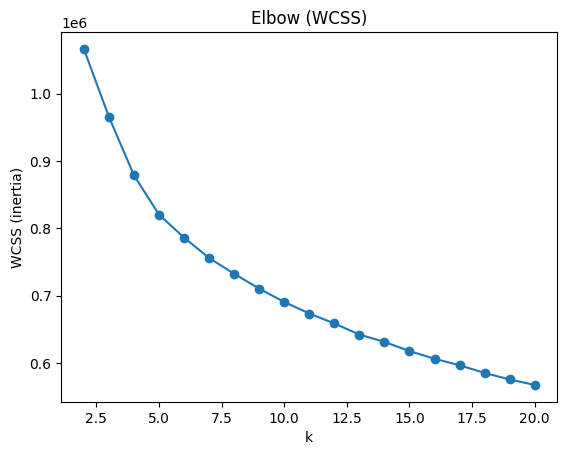

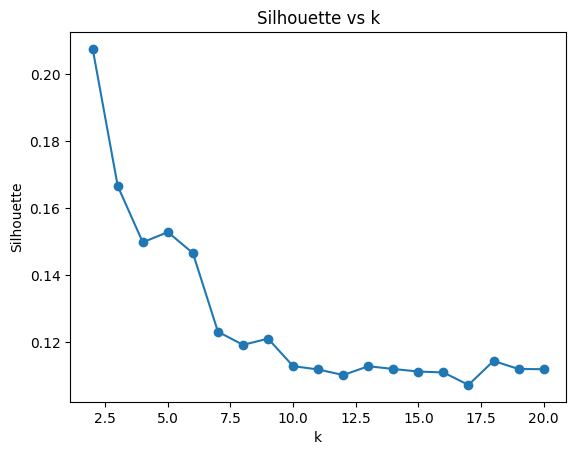

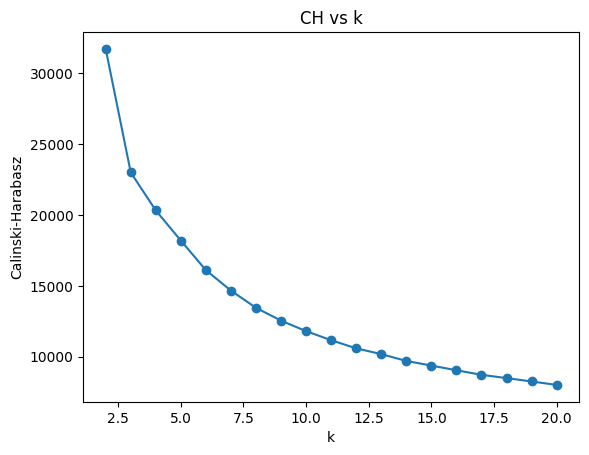

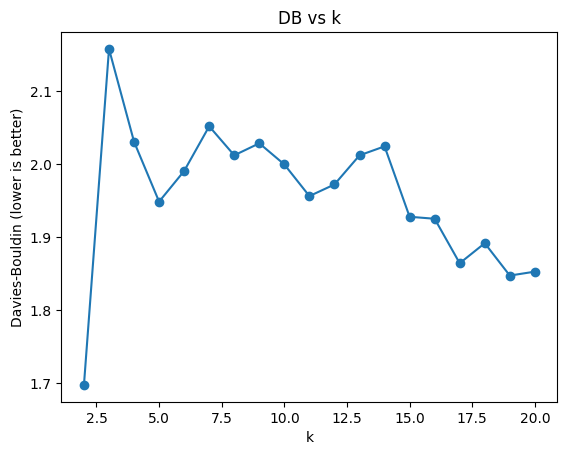

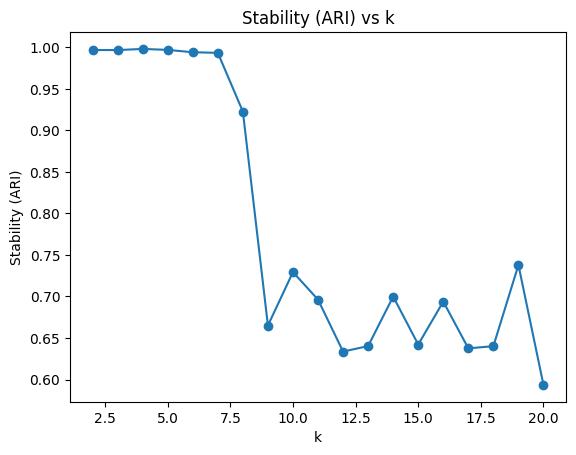

In [16]:
# ============================================================
# Cell 4：把結果視覺化（不要只看 elbow）
# ============================================================

import matplotlib.pyplot as plt

def plot_scores(scores):
    k = scores['k']

    # Elbow：WCSS 越小越好，但永遠會隨 k 增加而下降
    # 只看「彎折點」位置（改善幅度開始變小），不要用它當唯一選 K
    plt.figure()
    plt.plot(k, scores['wcss'], marker='o')
    plt.xlabel('k'); plt.ylabel('WCSS (inertia)')
    plt.title('Elbow (WCSS)'); plt.show()

    # Silhouette：越大越好（常用來選 K）
    plt.figure()
    plt.plot(k, scores['silhouette'], marker='o')
    plt.xlabel('k'); plt.ylabel('Silhouette')
    plt.title('Silhouette vs k'); plt.show()

    # Calinski-Harabasz：越大越好（常用來比較不同 K）
    plt.figure()
    plt.plot(k, scores['calinski_harabasz'], marker='o')
    plt.xlabel('k'); plt.ylabel('Calinski-Harabasz')
    plt.title('CH vs k'); plt.show()

    # Davies-Bouldin：越小越好（群越分離越低）
    plt.figure()
    plt.plot(k, scores['davies_bouldin'], marker='o')
    plt.xlabel('k'); plt.ylabel('Davies-Bouldin (lower is better)')
    plt.title('DB vs k'); plt.show()

    # 穩定度：ARI 越高越好（避免挑到不穩的 K）
    if 'stability_ari' in scores.columns:
        plt.figure()
        plt.plot(k, scores['stability_ari'], marker='o')
        plt.xlabel('k'); plt.ylabel('Stability (ARI)')
        plt.title('Stability (ARI) vs k'); plt.show()

plot_scores(scores)

In [17]:
# ============================================================
# Cell 5：自動挑「候選 K」（先看幾個不錯的，再靠可解釋性決定）
# ============================================================

def pick_candidates(scores, top_n=3):
    """
    不先硬選單一 K，而是挑幾個候選：
    - silhouette 前 top_n
    - stability_ari 前 top_n
    - davies_bouldin 最小 top_n
    之後再跑群輪廓，看哪個 K 最可解釋、最能落地
    """
    cands = set()
    cands |= set(scores.sort_values('silhouette', ascending=False).head(top_n)['k'])
    cands |= set(scores.sort_values('stability_ari', ascending=False).head(top_n)['k'])
    cands |= set(scores.sort_values('davies_bouldin', ascending=True).head(top_n)['k'])
    return sorted(cands)

candidates = pick_candidates(scores, top_n=3)
candidates


[2, 3, 4, 5, 19, 20]

In [25]:
# ============================================================
# Cell 6：對候選 K 建模 + 產出「不矛盾」的解讀表（群大小/行為輪廓/Top部門）
# ============================================================
from sklearn.cluster import KMeans

def fit_kmeans_and_profile(features_raw, X, k, behavior_cols, dept_cols):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)

    # user-level 結果：用原尺度 features_raw 方便解釋（幾天、幾單、比例）
    result_user = features_raw.copy()
    result_user['cluster'] = labels

    sizes = result_user['cluster'].value_counts().sort_index()
    behavior_profile = result_user.groupby('cluster')[behavior_cols].mean().round(4)

    top_depts = {}
    for c in sorted(result_user['cluster'].unique()):
        s = result_user[result_user['cluster']==c][dept_cols].mean().sort_values(ascending=False).head(5)
        top_depts[c] = list(s.index)

    return km, result_user, sizes, behavior_profile, top_depts

all_results = {}

for k in candidates:
    km, result_user, sizes, behavior_profile, top_depts = fit_kmeans_and_profile(
        features_raw=features_raw,
        X=X,
        k=k,
        behavior_cols=behavior_cols,
        dept_cols=dept_cols
    )

    all_results[k] = {
        "km": km,
        "result_user": result_user,         # user-level（含 cluster）
        "sizes": sizes,
        "behavior_profile": behavior_profile,
        "top_depts": top_depts
    }

    print("="*90)
    print(f"k = {k}")
    print("\n[群大小]\n", sizes.to_string())
    print("\n[行為輪廓（原尺度 mean）]\n", behavior_profile)
    print("\n[每群 Top 5 department（占比）]\n", top_depts)


k = 2

[群大小]
 cluster
0    42185
1    63088

[行為輪廓（原尺度 mean）]
          order_frequency  avg_days_between_orders  avg_basket_size  \
cluster                                                              
0                 3.0411                  10.3118          12.6226   
1                 1.1367                  13.6073           8.3870   

         reorder_ratio  diversity  is_new_user  dow_sin  dow_cos  hour_sin  \
cluster                                                                      
0                0.630     0.5261       0.0606   0.0351   0.0956   -0.1884   
1                0.474     0.7961       0.8757   0.0352   0.0836   -0.2307   

         hour_cos  total_items_purchased  reordered_count  unique_items  
cluster                                                                  
0         -0.5048                34.5941          22.3886       16.3672  
1         -0.4940                 8.8788           3.9076        6.6434  

[每群 Top 5 department（占比）]
 {0: ['produce', 'da

In [27]:
# ============================================================
# Cell 7：視覺化（群大小 / 行為輪廓熱圖 / 2D投影 / 你附圖那種 department grouped bar）
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_cluster_sizes(sizes, k):
    plt.figure()
    x = sizes.index.astype(int)
    y = sizes.values
    plt.bar(x, y)
    plt.xlabel("Cluster")
    plt.ylabel("Number of users")
    plt.title(f"Cluster sizes (k={k})")
    plt.tight_layout()
    plt.show()

def _zscore_columns(df):
    mu = df.mean(axis=0)
    sd = df.std(axis=0).replace(0, np.nan)
    z = (df - mu) / sd
    return z.fillna(0)

def plot_behavior_profile_heatmap(result_user, behavior_cols, k):
    z = _zscore_columns(result_user[behavior_cols])
    z['cluster'] = result_user['cluster'].values
    heat = z.groupby('cluster')[behavior_cols].mean()

    plt.figure()
    plt.imshow(heat.values, aspect='auto')
    plt.yticks(range(heat.shape[0]), [f"C{c}" for c in heat.index])
    plt.xticks(range(heat.shape[1]), heat.columns, rotation=90)
    plt.colorbar()
    plt.title(f"Behavior profile (z-score mean) (k={k})")
    plt.tight_layout()
    plt.show()

def plot_2d_projection(X, labels, k):
    pca2 = PCA(n_components=2, random_state=42)
    X2 = pca2.fit_transform(X)

    plt.figure()
    for c in sorted(np.unique(labels)):
        m = (labels == c)
        plt.scatter(X2[m, 0], X2[m, 1], s=10, alpha=0.5, label=f"C{c}")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.title(f"2D PCA projection colored by cluster (k={k})")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_dept_grouped_bar_like_example(items, result_user, k, top_n=10, add_other=True):
    """
    這張圖就是你附圖那種：每個 cluster 一組 bars，每個 department 一個顏色
    重點：用「商品列」計算該群實際購買件數占比（而不是每人平均占比）
    """
    # user_id 在 index 的情況
    user_clusters = result_user[['cluster']].reset_index().rename(columns={'index':'user_id'})

    items_with_c = items.merge(user_clusters, on='user_id', how='inner')

    dept_cnt = (
        items_with_c
        .groupby(['cluster','department'])
        .size()
        .unstack(fill_value=0)
    )
    dept_pct = dept_cnt.div(dept_cnt.sum(axis=1), axis=0) * 100

    # 可讀性：只取全體平均占比 top_n（其餘合併 Other）
    if top_n is not None and top_n < dept_pct.shape[1]:
        top_cols = dept_pct.mean(axis=0).sort_values(ascending=False).head(top_n).index
        dept_pct = dept_pct[top_cols].copy()
        if add_other:
            dept_pct['Other'] = 100 - dept_pct.sum(axis=1)

    ax = dept_pct.plot(kind='bar', figsize=(18, 6), width=0.85)
    ax.set_title(f"Product department per cluster (k={k})")
    ax.set_xlabel("Clusters")
    ax.set_ylabel("Percentage")
    ax.legend(title="Department", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    return dept_pct


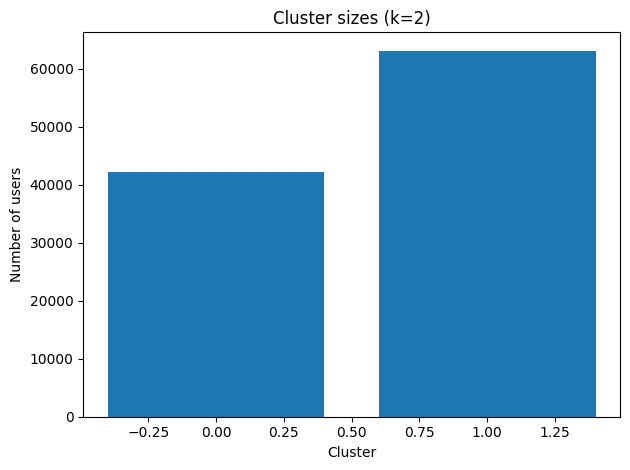

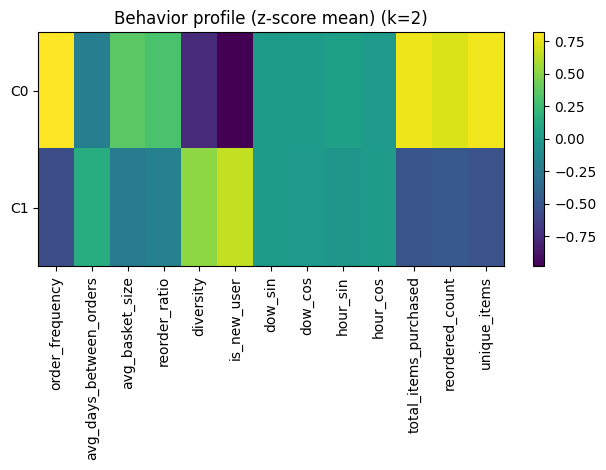

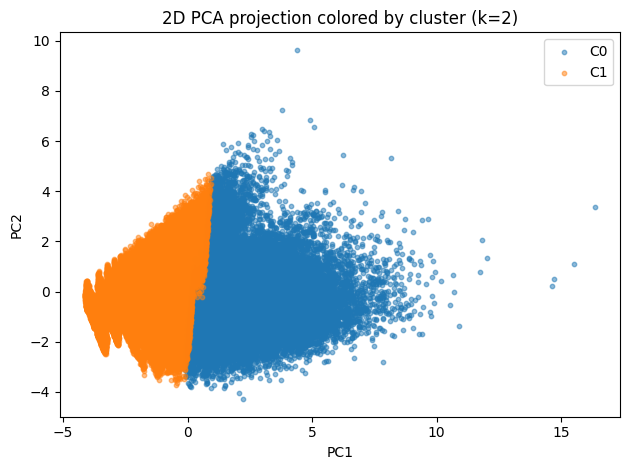

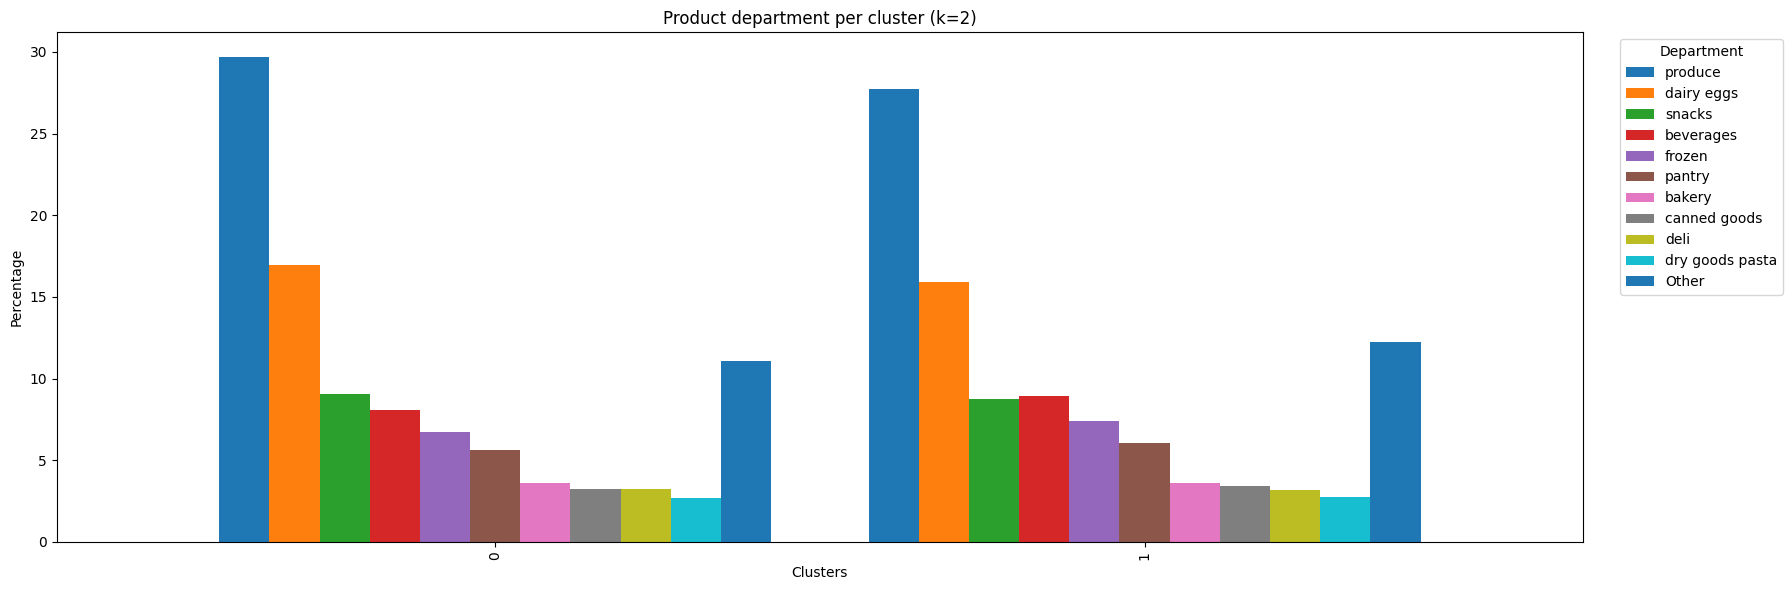

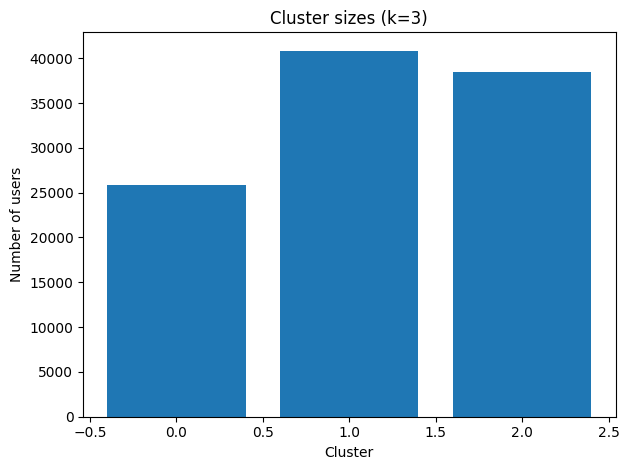

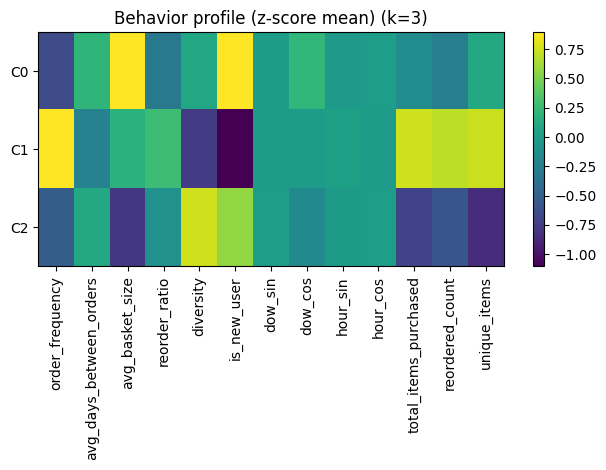

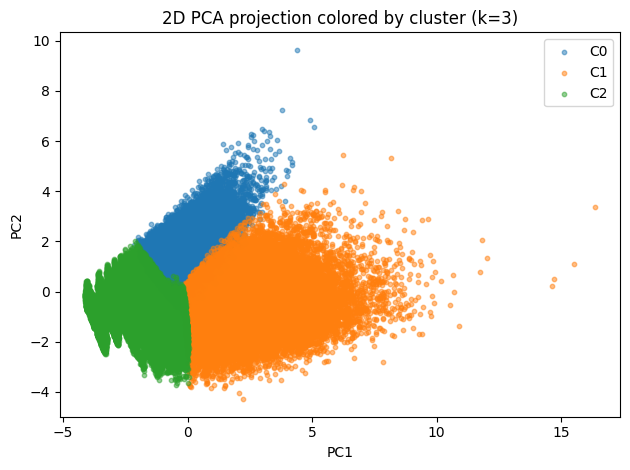

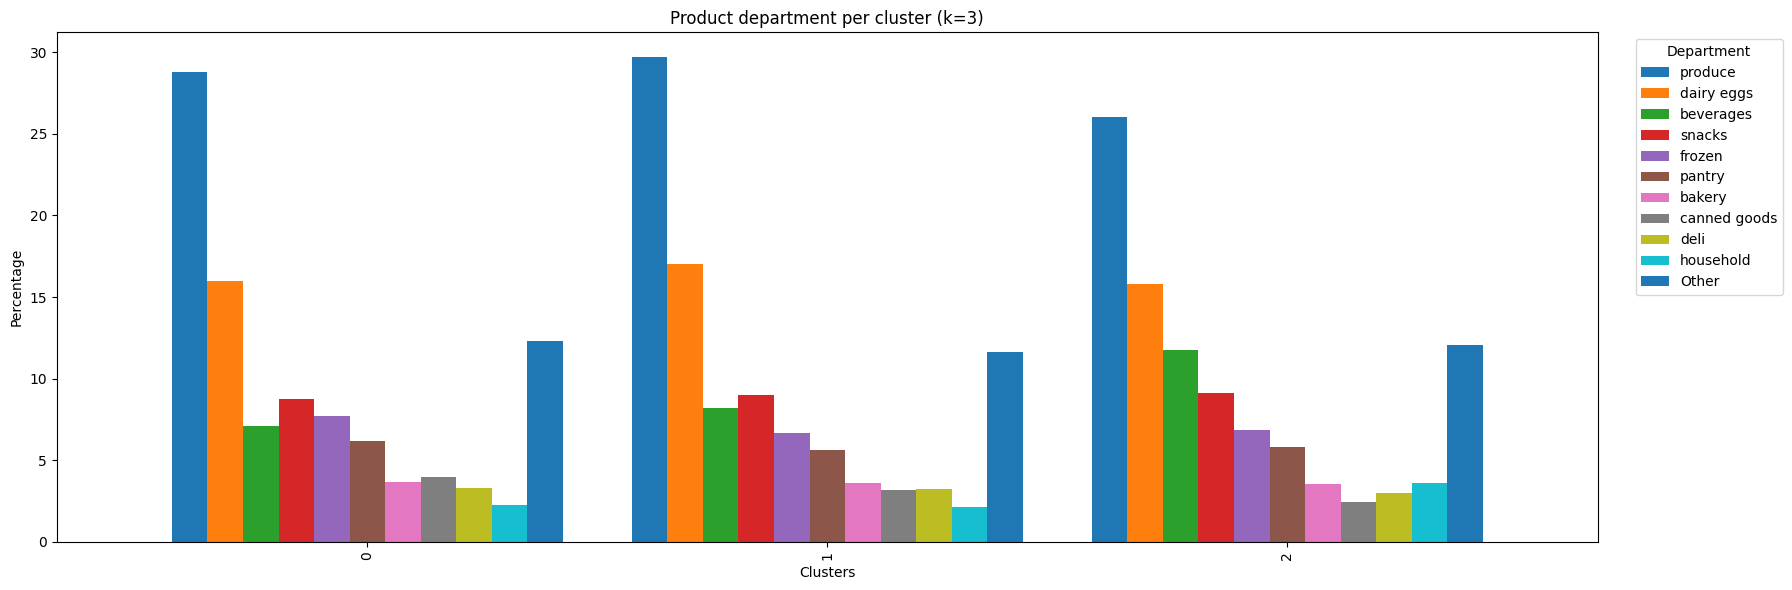

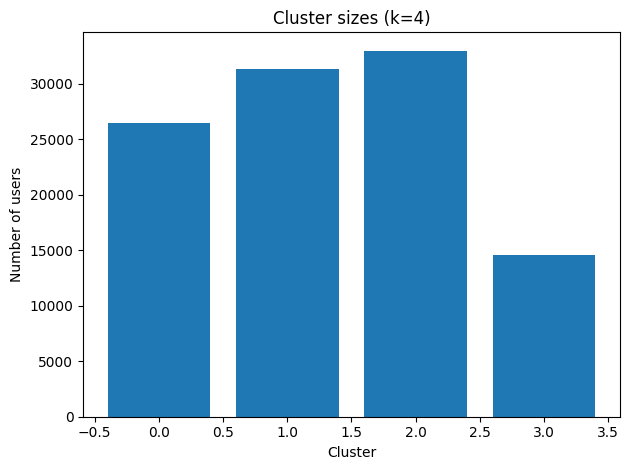

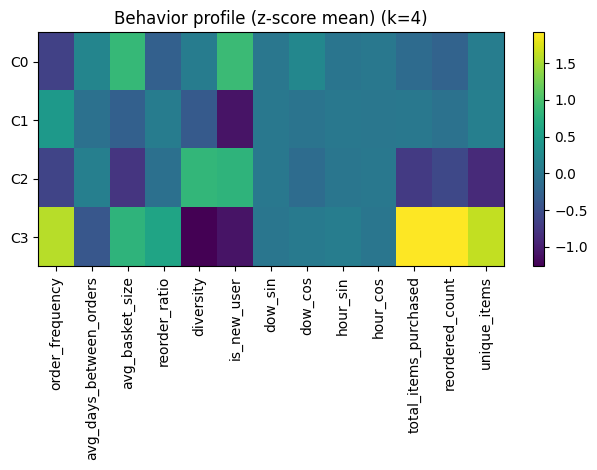

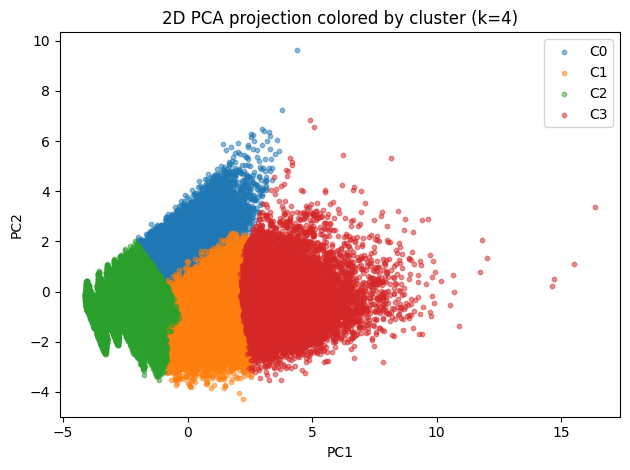

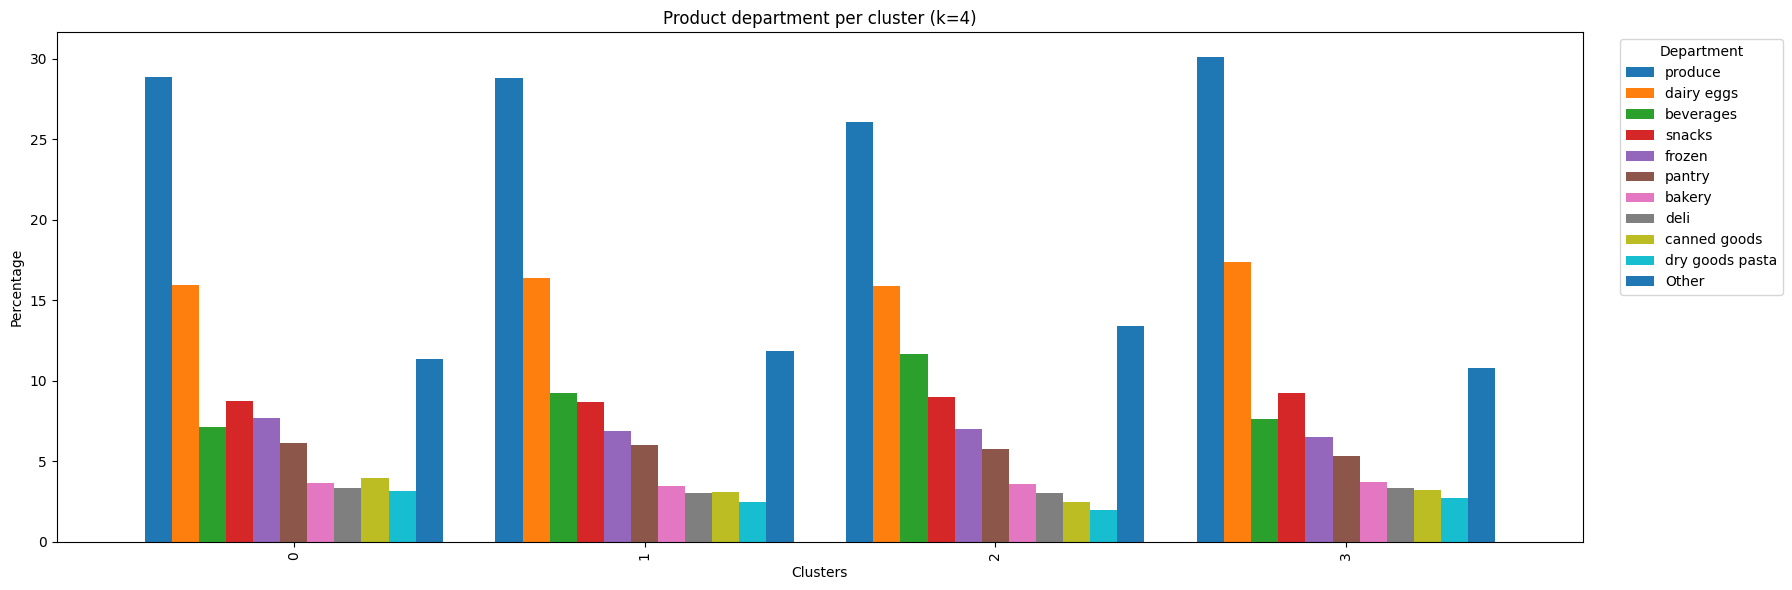

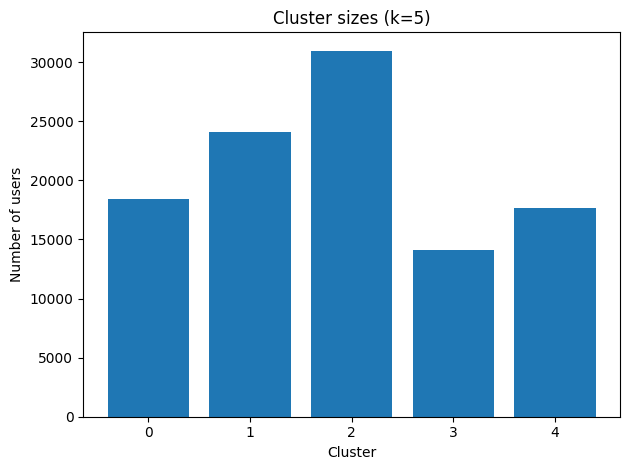

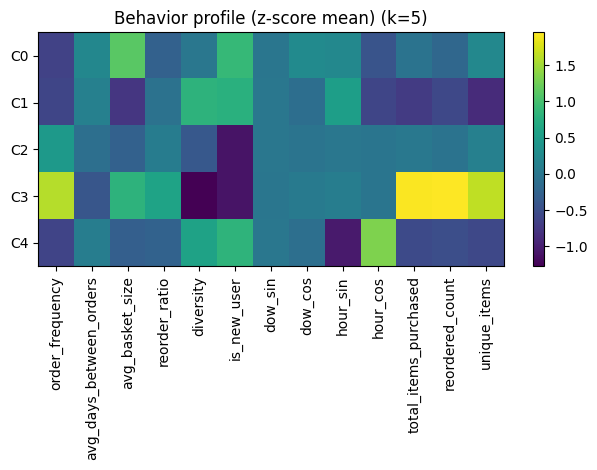

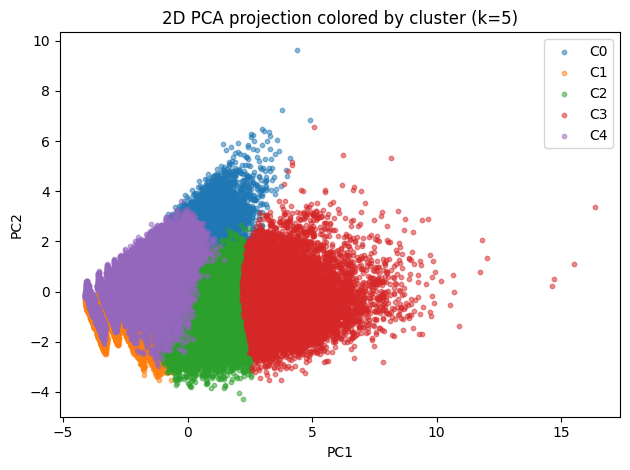

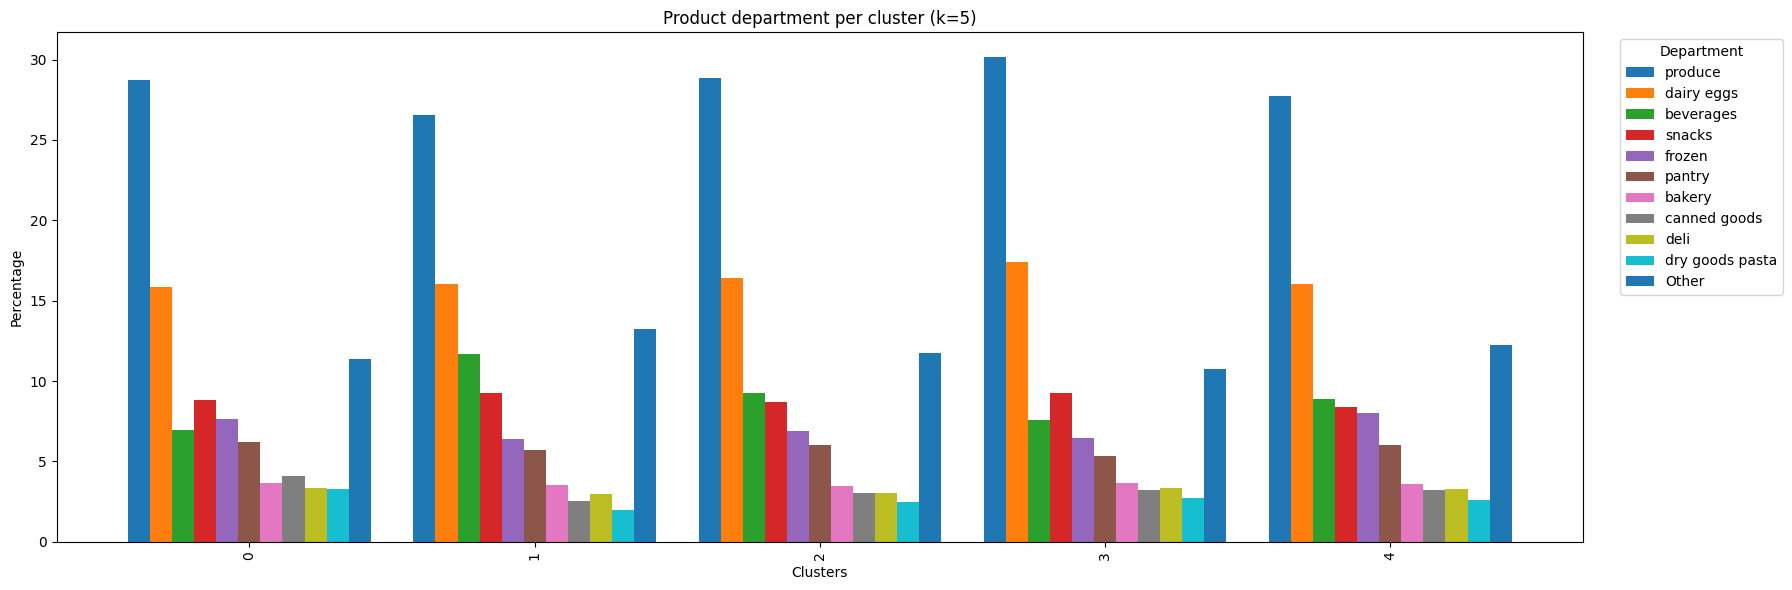

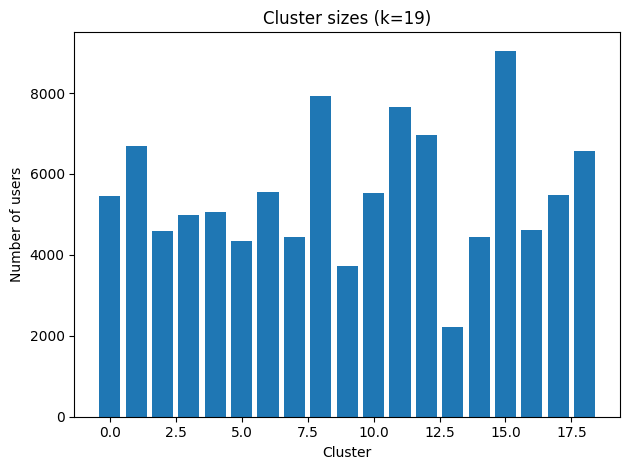

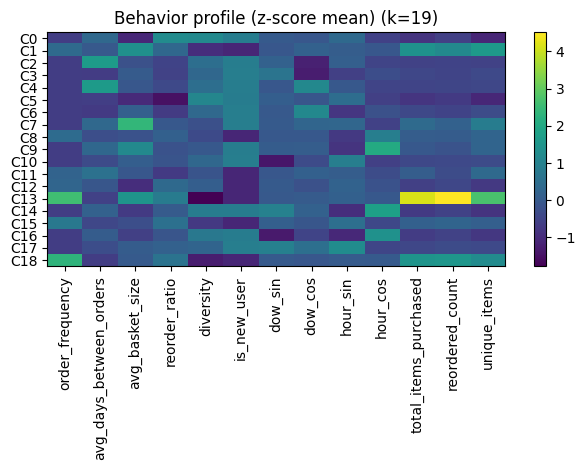

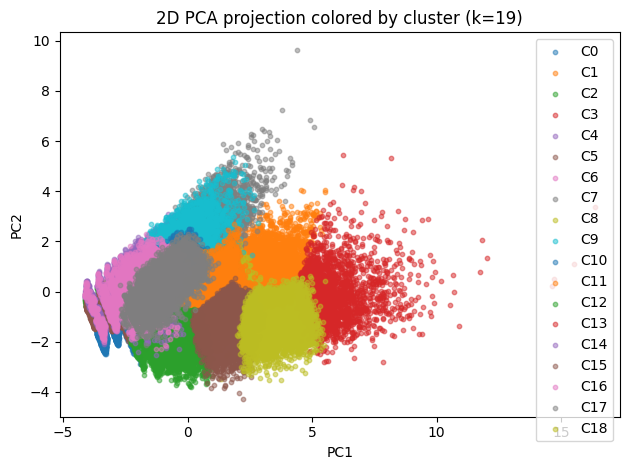

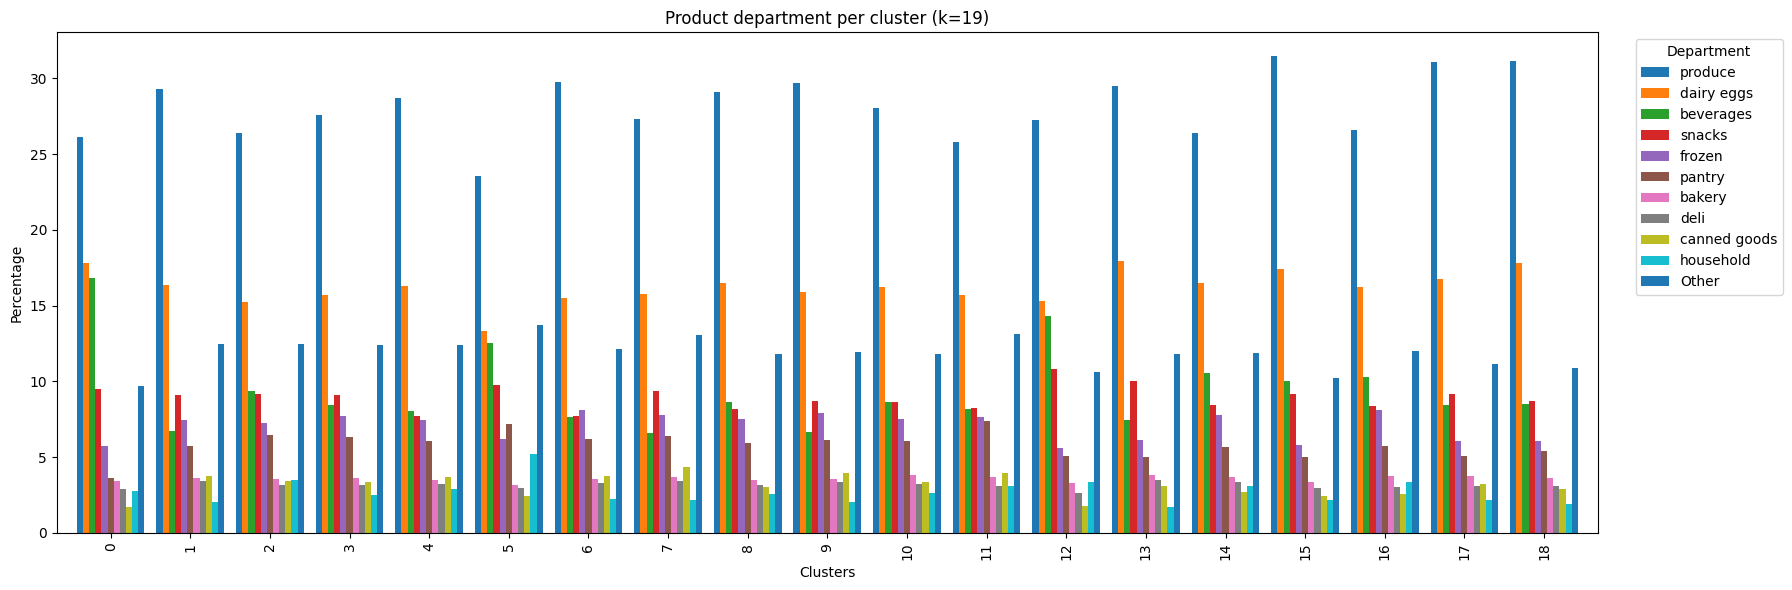

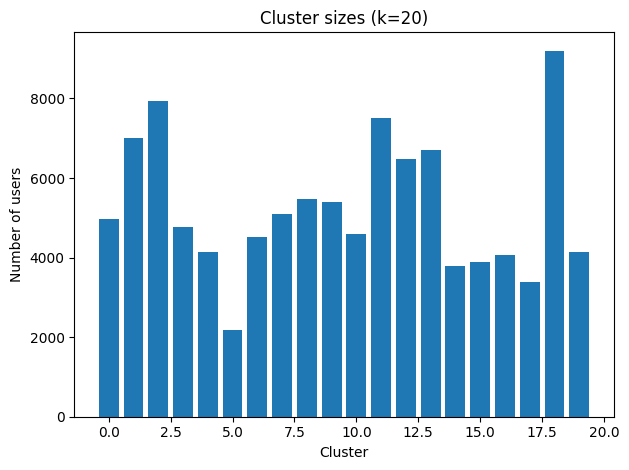

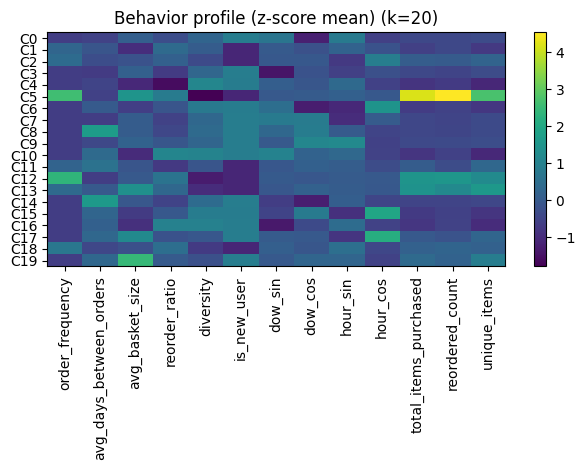

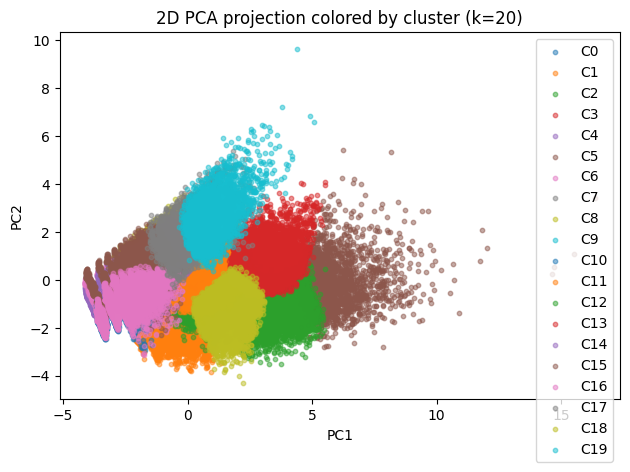

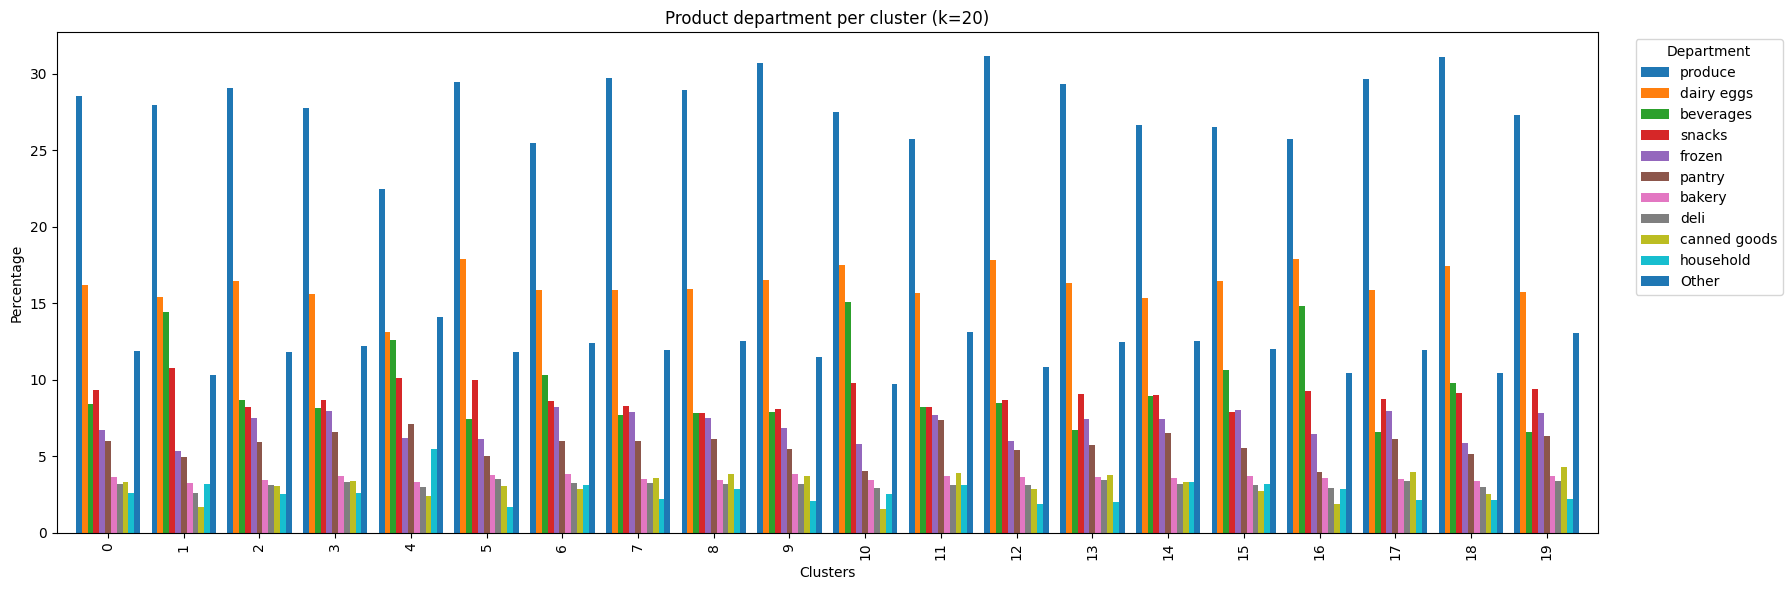

In [28]:
# ============================================================
# Cell 8：對候選 k 批次畫圖（你就用這些圖來決定最終 k）
# ============================================================
for k, pack in all_results.items():
    result_user = pack["result_user"]
    sizes = pack["sizes"]

    plot_cluster_sizes(sizes, k)
    plot_behavior_profile_heatmap(result_user, behavior_cols, k)
    plot_2d_projection(X, result_user['cluster'].values, k)

    # 你附圖那種 department grouped bar（建議 Top10+Other 更好讀）
    plot_dept_grouped_bar_like_example(items=data.copy(), result_user=result_user, k=k, top_n=10, add_other=True)
